# Approach

Now that we have preprocessed the two data sets - Train factors and Train Sentiment, we need to prepare the datsets for model building.

The order for doing this would be :
    
    1) We vectorize the lemmatized tweet text.
    
    2) We build a sentiment analysis model. 
    
    3) We combine the sentiment score obtained from the sentiment analysis model to the train factors dataset.
    
    4) We build a classification model to predict the alpha values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
import missingno as msno
import re, string, unicodedata
import nltk
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import string
import time
from time import sleep
from tqdm import tqdm_notebook as tq
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import scipy

# Reading the Dataset

## Train Factors

In [2]:
train_data = pd.read_csv('final_train_data.csv')

In [3]:
train_data.tail()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
27001,27001,27002,RF,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3,5,10
27002,27002,27003,PG,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3,30,7
27003,27003,27004,JCP,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2,16,10
27004,27004,27005,NVDA,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3,27,7
27005,27005,27006,WBA,-0.637959,0.621395,-0.636104,-0.810184,1.587782,-0.413540,0.101924,2,14,10


In [4]:
train_data.dtypes

Unnamed: 0      int64
Id              int64
ticker         object
SF1           float64
SF2           float64
SF3           float64
SF4           float64
SF5           float64
SF6           float64
SF7           float64
alpha           int64
Day             int64
Month           int64
dtype: object

In [5]:
train_data['ticker'] = train_data['ticker'].astype('category')

## Test Factors

In [6]:
test_data = pd.read_csv('final_test_data.csv')

print(test_data.tail())

print('\n\n', test_data.dtypes)

test_data['ticker'] = test_data['ticker'].astype('category')

       Unnamed: 0      Id ticker       SF1       SF2       SF3       SF4  \
11570       11570  281577      T -3.442316  0.455191  0.941669 -0.834807   
11571       11571  281578    WFC -1.650993 -0.499109 -0.771762 -2.645119   
11572       11572  281579    MAT -1.578543  1.482062  0.672188  0.908843   
11573       11573  281580     RF -0.027608  0.811717 -0.148925 -0.700263   
11574       11574  281581   bbby  0.591726  0.435771 -0.009138 -0.912432   

            SF5       SF6       SF7  Day  Month  
11570  0.278606 -0.233547 -2.755514    3     10  
11571  2.374321 -0.200878  0.353774   21      8  
11572 -0.259848 -0.136924 -2.101467   11      8  
11573  0.263678 -0.180345  0.435261   22      7  
11574 -0.410299  0.072242  1.063584   26      7  


 Unnamed: 0      int64
Id              int64
ticker         object
SF1           float64
SF2           float64
SF3           float64
SF4           float64
SF5           float64
SF6           float64
SF7           float64
Day             int6

## Sentiment Train

In [7]:
sent_data = pd.read_csv('final_sent_data.csv')

In [8]:
sent_data.tail()

,Unnamed: 0,sentiment_score,ticker,month_of_tweet,day_of_tweet,lemma_data,tweet_length,no_of_hashtags
1039126,1039126,2,CLF,8,13,[],1,0
1039127,1039127,3,AMD,9,4,[],1,0
1039128,1039128,0,FB,7,25,"['damn', 'short', 'hours', 'late']",48,0
1039129,1039129,0,AMD,9,28,['back'],14,0
1039130,1039130,2,AMZN,7,5,"['lag', 'tech', 'today']",25,0


In [9]:
sent_data.dtypes

Unnamed: 0          int64
sentiment_score     int64
ticker             object
month_of_tweet      int64
day_of_tweet        int64
lemma_data         object
tweet_length        int64
no_of_hashtags      int64
dtype: object

In [10]:
sent_data['ticker'] = sent_data['ticker'].astype('category')

## Sentiment Test

In [11]:
sent_data_test = pd.read_csv('final_sent_data_test.csv')

print(sent_data_test.tail())

print('\n\n', sent_data_test.dtypes)

sent_data_test['ticker'] = sent_data_test['ticker'].astype('category')

        Unnamed: 0 ticker  month_of_tweet  day_of_tweet  \
265017      265017    CVS               7            20   
265018      265018      S              10            24   
265019      265019    AMD               7            25   
265020      265020    TSN               8             6   
265021      265021   AAPL               9            27   

                                               lemma_data  tweet_length  \
265017  ['recent', 'bad', 'pr', 'make', 'easy', 'pick'...           120   
265018  ['heres', 'estimize', 'analysts', 'believe', '...            77   
265019  ['could', 'high', 'still', 'get', 'later', 'ye...           110   
265020                              ['file', 'form', 'q']            14   
265021  ['look', 'like', 'solidly', 'support', 'gain',...           126   

        no_of_hashtags  
265017               0  
265018               0  
265019               0  
265020               0  
265021               0  


 Unnamed: 0         int64
ticker          

# Sentiment Analysis Model

## Preparing Dataframe for Prediction

### Train

The lemmatized tweets are enclosed within a list. We need to strip the list format.

In [12]:
sent_data['lemma_data'][1]

"['despite', 'china', 'trade', 'war', 'hold', 'well']"

In [13]:
## The lemmatized words and in a list which is enclosed within a string. 
##So we define a function to convert enclosed list to list.

def convert(list):
    return eval(list)

In [14]:
sent_data['lemma'] = sent_data['lemma_data'].apply(lambda x: convert(x))

In [15]:
sent_data['processed_tweets'] = sent_data['lemma'].apply(lambda x: ' '.join(x))

In [16]:
sent_data.tail()

,Unnamed: 0,sentiment_score,ticker,month_of_tweet,day_of_tweet,lemma_data,tweet_length,no_of_hashtags,lemma,processed_tweets
1039126,1039126,2,CLF,8,13,[],1,0,[],
1039127,1039127,3,AMD,9,4,[],1,0,[],
1039128,1039128,0,FB,7,25,"['damn', 'short', 'hours', 'late']",48,0,"[damn, short, hours, late]",damn short hours late
1039129,1039129,0,AMD,9,28,['back'],14,0,[back],back
1039130,1039130,2,AMZN,7,5,"['lag', 'tech', 'today']",25,0,"[lag, tech, today]",lag tech today


**We only keep the processed_tweets text column and also remove the rows where length of processed tweets is 0.**

In [17]:
final_sent_train = sent_data.drop(columns=['lemma_data', 'lemma', 'Unnamed: 0'])

In [18]:
final_sent_train = final_sent_train.loc[final_sent_train['tweet_length'] != 1]

In [19]:
final_sent_train.shape

(1020484, 7)

In [20]:
final_sent_train.head(2)

,sentiment_score,ticker,month_of_tweet,day_of_tweet,tweet_length,no_of_hashtags,processed_tweets
0,3,AMD,9,19,70,0,go hesitate however chart stable go upward
1,3,CAT,10,9,42,0,despite china trade war hold well


### Test

In [21]:
## The lemmatized words and in a list which is enclosed within a string. 
##So we define a function to convert enclosed list to list.

def convert(list):
    return eval(list)

sent_data_test['lemma'] = sent_data_test['lemma_data'].apply(lambda x: convert(x))

sent_data_test['processed_tweets'] = sent_data_test['lemma'].apply(lambda x: ' '.join(x))

print(sent_data_test.tail())

final_sent_test = sent_data_test.drop(columns=['lemma_data', 'lemma', 'Unnamed: 0'])

final_sent_test = final_sent_test.loc[final_sent_test['tweet_length'] != 1]

print('\n\n', final_sent_test.head(2))

        Unnamed: 0 ticker  month_of_tweet  day_of_tweet  \
265017      265017    CVS               7            20   
265018      265018      S              10            24   
265019      265019    AMD               7            25   
265020      265020    TSN               8             6   
265021      265021   AAPL               9            27   

                                               lemma_data  tweet_length  \
265017  ['recent', 'bad', 'pr', 'make', 'easy', 'pick'...           120   
265018  ['heres', 'estimize', 'analysts', 'believe', '...            77   
265019  ['could', 'high', 'still', 'get', 'later', 'ye...           110   
265020                              ['file', 'form', 'q']            14   
265021  ['look', 'like', 'solidly', 'support', 'gain',...           126   

        no_of_hashtags                                              lemma  \
265017               0  [recent, bad, pr, make, easy, pick, load, than...   
265018               0  [heres, estimize

In [22]:
final_sent_test.head()

,ticker,month_of_tweet,day_of_tweet,tweet_length,no_of_hashtags,processed_tweets
0,CELG,10,25,27,0,nothing exit
1,AMD,7,13,55,0,yall exhaust buyer first green candle byeeeeee
2,AMD,9,25,16,0,day traders day
4,MU,7,31,101,0,weak price action far today dont afraid go sho...
5,AMZN,8,4,118,0,continue grow specifically key areas like clou...


## Seperating X & Y

In [23]:
X_sent = final_sent_train.drop(columns='sentiment_score')
y_sent = final_sent_train['sentiment_score']

## Train Validation Split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
x_train_sent, x_val_sent, y_train_sent, y_val_sent = train_test_split(X_sent, y_sent, test_size = 0.2, random_state = 26, stratify = y_sent)

In [26]:
print('X Train dimensions: \n\n', x_train_sent.shape, '\n\nX Validation dimensions: \n\n', x_val_sent.shape, 
      '\n\nY Train dimensions:\n\n', y_train_sent.shape, '\n\n Y Validation dimensions: \n\n', y_val_sent.shape)

X Train dimensions: 

 (816387, 6) 

X Validation dimensions: 

 (204097, 6) 

Y Train dimensions:

 (816387,) 

 Y Validation dimensions: 

 (204097,)


## One Hot Encoding - Ticker

In [27]:
encoded_ticker_train = pd.get_dummies(x_train_sent['ticker'])
encoded_ticker_val = pd.get_dummies(x_val_sent['ticker'])
encoded_ticker_test = pd.get_dummies(final_sent_test['ticker'])

**Since the encoded dimensions of ticker for train, validation and test data wont be the same (because some all the tickers won't be present in the val & test), so we reindex the validation and test dataframes with train dataframe columns and fill the values with 0s.**

In [28]:
encoded_ticker_val = encoded_ticker_val.reindex(columns = encoded_ticker_train.columns, fill_value=0)

In [29]:
encoded_ticker_test = encoded_ticker_test.reindex(columns = encoded_ticker_train.columns, fill_value=0)

In [30]:
print(encoded_ticker_train.shape, encoded_ticker_val.shape, encoded_ticker_test.shape)

(816387, 2166) (204097, 2166) (260123, 2166)


**We convert these encoded dataframes to scipy compressed matrices (to reduce memory consumption).**

In [31]:
encoded_ticker_train_matrix = scipy.sparse.csr_matrix(encoded_ticker_train.values)

In [32]:
encoded_ticker_val_matrix = scipy.sparse.csr_matrix(encoded_ticker_val.values)

In [33]:
encoded_ticker_test_matrix = scipy.sparse.csr_matrix(encoded_ticker_test.values)

## TF-IDF Vectorizer

In [34]:
vectorizer = TfidfVectorizer(stop_words="english")

In [35]:
vectorizer.fit(x_train_sent['processed_tweets'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [36]:
vectorizer.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaaa',
 'aaaaaaaaaaaa',
 'aaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaa',
 'aaaaaaaaaaaaaaaaaaand',
 'aaaaaaaaaaaammmmmmmmmddddddddd',
 'aaaaaaaaaaahhhhh',
 'aaaaaaaaaaand',
 'aaaaaaaaaah',
 'aaaaaaaaaand',
 'aaaaaaaaahhhhh',
 'aaaaaaaaand',
 'aaaaaaaaapl',
 'aaaaaaaah',
 'aaaaaaaand',
 'aaaaaaah',
 'aaaaaaand',
 'aaaaaaannnndd',
 'aaaaaaannnnndddddd',
 'aaaaaagggggaaaaaaiiiiiinnnnnnnnnn',
 'aaaaaahhhhhh',
 'aaaaaahhhhhhhhaaa',
 'aaaaaand',
 'aaaaaannd',
 'aaaaaannnd',
 'aaaaaannnndddddstill',
 'aaaaah',
 'aaaaahaha',
 'aaaaahahahahaha',
 'aaaaahhh',
 'aaaaand',
 'aaaaandddd',
 'aaaaannnnd',
 'aaaaay',
 'aaaaayyyyeeeee',
 'aaaagain',
 'aaaagggg',
 'aaaaghhhh',
 'aaaah',
 'aaaahahahhhaha',
 'aaaamazingaa',
 'aaaamazzzing',
 'aaaand',
 'aaaandd',
 'aaaandred',
 'aaaannnd',
 'aaaannnddd',
 'aaaannnnd',
 'aaaannnnddd',
 'aaaannnnnddd',
 'aaaawwrggg',
 'aaaay',
 'aaaddded',
 'aaah',
 'aaahahahahhahah',
 'aaahhh',
 'aaahhhh',
 'aaahhhhh',
 'aaamp',
 'aaand',
 'aaannnd',
 

In [37]:
x_train_tfidf = vectorizer.transform(x_train_sent['processed_tweets'])
x_val_tfidf = vectorizer.transform(x_val_sent['processed_tweets'])
x_test_tfidf = vectorizer.transform(final_sent_test['processed_tweets'])

In [38]:
print(x_train_tfidf.shape, x_val_tfidf.shape, x_test_tfidf.shape)

(816387, 106354) (204097, 106354) (260123, 106354)


In [39]:
print(encoded_ticker_train_matrix.shape, encoded_ticker_val_matrix.shape, encoded_ticker_test_matrix.shape)

(816387, 2166) (204097, 2166) (260123, 2166)


In [40]:
print(x_train_sent.columns, x_val_sent.columns, final_sent_test.columns)

Index(['ticker', 'month_of_tweet', 'day_of_tweet', 'tweet_length',
       'no_of_hashtags', 'processed_tweets'],
      dtype='object') Index(['ticker', 'month_of_tweet', 'day_of_tweet', 'tweet_length',
       'no_of_hashtags', 'processed_tweets'],
      dtype='object') Index(['ticker', 'month_of_tweet', 'day_of_tweet', 'tweet_length',
       'no_of_hashtags', 'processed_tweets'],
      dtype='object')


**Now, we merge the one hot encoded matrices with the tf-idf vectorized matrices. This is because we need both the matrices for prediction.**

In [41]:
from scipy.sparse import hstack

In [42]:
sent_train = hstack((encoded_ticker_train_matrix, x_train_tfidf))
sent_val = hstack((encoded_ticker_val_matrix, x_val_tfidf))
sent_test = hstack((encoded_ticker_test_matrix, x_test_tfidf))

**Having merged the encoded and vectorized matrices, we now add more features to these merged matrices to help imporove prediction.**

In [43]:
def add_feature(X, feature_to_add):
   
    # Returns sparse feature matrix with added feature.
    # Feature_to_add can also be a list of features.
   
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [44]:
x_sent_train = add_feature(sent_train, [x_train_sent['month_of_tweet'], x_train_sent['day_of_tweet'], 
                                        x_train_sent['tweet_length'], x_train_sent['no_of_hashtags']])

x_sent_val = add_feature(sent_val, [x_val_sent['month_of_tweet'], x_val_sent['day_of_tweet'], 
                                        x_val_sent['tweet_length'], x_val_sent['no_of_hashtags']])

x_sent_test = add_feature(sent_test, [final_sent_test['month_of_tweet'], final_sent_test['day_of_tweet'], 
                                        final_sent_test['tweet_length'], final_sent_test['no_of_hashtags']])

In [45]:
print(x_sent_train.shape, x_sent_val.shape, x_sent_test.shape)

(816387, 108524) (204097, 108524) (260123, 108524)


## Deep Learning - LSTM

### Load Error Metrics

In [64]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,f1_score,precision_score
from sklearn.metrics import roc_curve,log_loss,auc

### Model

In [46]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

Using TensorFlow backend.


In [47]:
final_sent_test.head()

,ticker,month_of_tweet,day_of_tweet,tweet_length,no_of_hashtags,processed_tweets
0,CELG,10,25,27,0,nothing exit
1,AMD,7,13,55,0,yall exhaust buyer first green candle byeeeeee
2,AMD,9,25,16,0,day traders day
4,MU,7,31,101,0,weak price action far today dont afraid go sho...
5,AMZN,8,4,118,0,continue grow specifically key areas like clou...


**Converting the processsed tweets and the sentiment score to numpy arrays.**

In [48]:
clean_tweets_train = np.array(x_train_sent['processed_tweets'])
clean_tweets_val = np.array(x_val_sent['processed_tweets'])
clean_tweets_test = np.array(final_sent_test['processed_tweets']) 
sentiments_train = np.array(y_train_sent)
sentiments_val = np.array(y_val_sent)

**Converting the sentiment scores to categorical type.**

In [49]:
y_train = to_categorical(sentiments_train)
y_val = to_categorical(sentiments_val)

In [50]:
tokenizer = Tokenizer(num_words=10000, split=' ', oov_token=False)
tokenizer.fit_on_texts(clean_tweets_train)
tokenizer.word_index

{False: 1,
 'buy': 2,
 'go': 3,
 'report': 4,
 'short': 5,
 'q': 6,
 'get': 7,
 'call': 8,
 'trade': 9,
 'sell': 10,
 'stock': 11,
 'today': 12,
 'earn': 13,
 'share': 14,
 'see': 15,
 'like': 16,
 'estimize': 17,
 'volume': 18,
 'look': 19,
 'market': 20,
 'back': 21,
 'day': 22,
 'good': 23,
 'next': 24,
 'hold': 25,
 'analysts': 26,
 'price': 27,
 'time': 28,
 'come': 29,
 'new': 30,
 'put': 31,
 'eps': 32,
 'tomorrow': 33,
 'still': 34,
 'long': 35,
 'week': 36,
 'bear': 37,
 'close': 38,
 'expect': 39,
 'last': 40,
 'revenue': 41,
 'move': 42,
 'make': 43,
 'think': 44,
 'dont': 45,
 'growth': 46,
 'lol': 47,
 'im': 48,
 'take': 49,
 'say': 50,
 'bull': 51,
 'amc': 52,
 'bmo': 53,
 'let': 54,
 'er': 55,
 'higher': 56,
 'big': 57,
 'expmaxpainhighputoihighcalloi': 58,
 'break': 59,
 'alert': 60,
 'one': 61,
 'open': 62,
 'since': 63,
 'update': 64,
 'money': 65,
 'drop': 66,
 'believe': 67,
 'need': 68,
 'insider': 69,
 'know': 70,
 'amd': 71,
 'low': 72,
 'days': 73,
 'amp': 74,
 

**Since the LSTM model requires the input dimensions to be the same, we find the maximum length of a tweet in train, validation and test. We first tokenize the tweet using texts_to_sequences, dummify the categorical sentiment score and then pad them using the max length (equal to max length of the tweet).**

In [51]:
X_train_tok = tokenizer.texts_to_sequences(clean_tweets_train)
X_val_tok = tokenizer.texts_to_sequences(clean_tweets_val)
X_test_tok = tokenizer.texts_to_sequences(clean_tweets_test)

max_length_train = max([len(i) for i in X_train_tok])
max_length_val = max([len(i) for i in X_val_tok])
max_length_test = max([len(i) for i in X_test_tok])

max_length = max(max_length_train, max_length_val, max_length_test)

print("The maximum length of a tweet is - ", max_length)

The maximum length of a tweet is -  43


In [52]:
encoded_sentiment_train = np.array(pd.get_dummies(sentiments_train))
encoded_sentiment_val = np.array(pd.get_dummies(sentiments_val))
print(encoded_sentiment_train, '\n\n', encoded_sentiment_val)

[[0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 ...
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 0 1 0 0]] 

 [[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 ...
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]]


In [53]:
X_train_sent = pad_sequences(X_train_tok, maxlen=max_length, padding='post')
X_val_sent = pad_sequences(X_val_tok, maxlen=max_length, padding='post')
X_test_sent = pad_sequences(X_test_tok, maxlen=max_length, padding='post')

print(X_train_sent.shape, X_val_sent.shape, X_test_sent.shape)

(816387, 43) (204097, 43) (260123, 43)


In [54]:
embed_dim = 128
lstm_out = 64

In [55]:
model = Sequential()
model.add(Embedding(10000, embed_dim, input_length = X_train_sent.shape[1]))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 43, 128)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 43, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,329,733
Trainable params: 1,329,733
Non-trainable params: 0
_________________________________________________________________
None


In [56]:
batch_size = 100
history = model.fit(X_train_sent, encoded_sentiment_train, epochs = 2, batch_size=batch_size, verbose=1, validation_split=0.3)

Instructions for updating:
Use tf.cast instead.
Train on 571470 samples, validate on 244917 samples
Epoch 1/2


 17700/571470 [..............................] - ETA: 1:10:29 - loss: 1.6100 - accuracy: 0.140 - ETA: 41:06 - loss: 1.6049 - accuracy: 0.2250  - ETA: 31:00 - loss: 1.5950 - accuracy: 0.296 - ETA: 25:42 - loss: 1.5902 - accuracy: 0.315 - ETA: 22:46 - loss: 1.5829 - accuracy: 0.334 - ETA: 21:07 - loss: 1.5782 - accuracy: 0.341 - ETA: 19:47 - loss: 1.5669 - accuracy: 0.360 - ETA: 18:45 - loss: 1.5586 - accuracy: 0.370 - ETA: 17:58 - loss: 1.5535 - accuracy: 0.372 - ETA: 17:15 - loss: 1.5415 - accuracy: 0.384 - ETA: 16:52 - loss: 1.5354 - accuracy: 0.386 - ETA: 16:20 - loss: 1.5334 - accuracy: 0.386 - ETA: 15:56 - loss: 1.5180 - accuracy: 0.398 - ETA: 15:37 - loss: 1.5075 - accuracy: 0.407 - ETA: 15:19 - loss: 1.5017 - accuracy: 0.412 - ETA: 15:02 - loss: 1.4907 - accuracy: 0.418 - ETA: 14:47 - loss: 1.4892 - accuracy: 0.418 - ETA: 14:34 - loss: 1.4856 - accuracy: 0.420 - ETA: 14:22 - loss: 1.4838 - accuracy: 0.422 - ETA: 14:12 - loss: 1.4848 - accuracy: 0.421 - ETA: 13:59 - loss: 1.4747 -

 35500/571470 [>.............................] - ETA: 11:16 - loss: 1.4427 - accuracy: 0.442 - ETA: 11:15 - loss: 1.4425 - accuracy: 0.442 - ETA: 11:15 - loss: 1.4427 - accuracy: 0.442 - ETA: 11:15 - loss: 1.4424 - accuracy: 0.442 - ETA: 11:14 - loss: 1.4425 - accuracy: 0.442 - ETA: 11:14 - loss: 1.4430 - accuracy: 0.442 - ETA: 11:14 - loss: 1.4431 - accuracy: 0.442 - ETA: 11:14 - loss: 1.4425 - accuracy: 0.442 - ETA: 11:14 - loss: 1.4423 - accuracy: 0.443 - ETA: 11:14 - loss: 1.4415 - accuracy: 0.443 - ETA: 11:14 - loss: 1.4417 - accuracy: 0.443 - ETA: 11:13 - loss: 1.4412 - accuracy: 0.443 - ETA: 11:13 - loss: 1.4412 - accuracy: 0.443 - ETA: 11:13 - loss: 1.4406 - accuracy: 0.444 - ETA: 11:12 - loss: 1.4407 - accuracy: 0.444 - ETA: 11:12 - loss: 1.4408 - accuracy: 0.444 - ETA: 11:12 - loss: 1.4410 - accuracy: 0.444 - ETA: 11:11 - loss: 1.4412 - accuracy: 0.443 - ETA: 11:11 - loss: 1.4411 - accuracy: 0.444 - ETA: 11:11 - loss: 1.4412 - accuracy: 0.443 - ETA: 11:11 - loss: 1.4408 - acc

 53300/571470 [=>............................] - ETA: 10:39 - loss: 1.4351 - accuracy: 0.445 - ETA: 10:38 - loss: 1.4353 - accuracy: 0.445 - ETA: 10:38 - loss: 1.4354 - accuracy: 0.445 - ETA: 10:38 - loss: 1.4353 - accuracy: 0.445 - ETA: 10:38 - loss: 1.4353 - accuracy: 0.445 - ETA: 10:38 - loss: 1.4354 - accuracy: 0.445 - ETA: 10:38 - loss: 1.4355 - accuracy: 0.445 - ETA: 10:37 - loss: 1.4356 - accuracy: 0.445 - ETA: 10:37 - loss: 1.4356 - accuracy: 0.445 - ETA: 10:37 - loss: 1.4357 - accuracy: 0.445 - ETA: 10:37 - loss: 1.4358 - accuracy: 0.445 - ETA: 10:37 - loss: 1.4357 - accuracy: 0.445 - ETA: 10:36 - loss: 1.4358 - accuracy: 0.445 - ETA: 10:36 - loss: 1.4356 - accuracy: 0.445 - ETA: 10:36 - loss: 1.4354 - accuracy: 0.446 - ETA: 10:36 - loss: 1.4355 - accuracy: 0.445 - ETA: 10:36 - loss: 1.4356 - accuracy: 0.445 - ETA: 10:36 - loss: 1.4356 - accuracy: 0.445 - ETA: 10:35 - loss: 1.4357 - accuracy: 0.445 - ETA: 10:35 - loss: 1.4357 - accuracy: 0.445 - ETA: 10:35 - loss: 1.4357 - acc

 71400/571470 [==>...........................] - ETA: 10:12 - loss: 1.4361 - accuracy: 0.444 - ETA: 10:12 - loss: 1.4362 - accuracy: 0.444 - ETA: 10:12 - loss: 1.4362 - accuracy: 0.443 - ETA: 10:12 - loss: 1.4362 - accuracy: 0.443 - ETA: 10:12 - loss: 1.4362 - accuracy: 0.443 - ETA: 10:12 - loss: 1.4362 - accuracy: 0.443 - ETA: 10:11 - loss: 1.4362 - accuracy: 0.443 - ETA: 10:11 - loss: 1.4363 - accuracy: 0.443 - ETA: 10:11 - loss: 1.4363 - accuracy: 0.443 - ETA: 10:11 - loss: 1.4363 - accuracy: 0.443 - ETA: 10:11 - loss: 1.4361 - accuracy: 0.443 - ETA: 10:11 - loss: 1.4362 - accuracy: 0.443 - ETA: 10:10 - loss: 1.4363 - accuracy: 0.443 - ETA: 10:10 - loss: 1.4364 - accuracy: 0.443 - ETA: 10:10 - loss: 1.4363 - accuracy: 0.443 - ETA: 10:10 - loss: 1.4363 - accuracy: 0.443 - ETA: 10:10 - loss: 1.4362 - accuracy: 0.443 - ETA: 10:10 - loss: 1.4362 - accuracy: 0.443 - ETA: 10:10 - loss: 1.4363 - accuracy: 0.443 - ETA: 10:10 - loss: 1.4364 - accuracy: 0.443 - ETA: 10:09 - loss: 1.4365 - acc

 90000/571470 [===>..........................] - ETA: 9:52 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:52 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:52 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:52 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:52 - loss: 1.4351 - accuracy: 0.44 - ETA: 9:52 - loss: 1.4351 - accuracy: 0.44 - ETA: 9:52 - loss: 1.4350 - accuracy: 0.44 - ETA: 9:52 - loss: 1.4350 - accuracy: 0.44 - ETA: 9:51 - loss: 1.4351 - accuracy: 0.44 - ETA: 9:51 - loss: 1.4350 - accuracy: 0.44 - ETA: 9:51 - loss: 1.4350 - accuracy: 0.44 - ETA: 9:51 - loss: 1.4350 - accuracy: 0.44 - ETA: 9:51 - loss: 1.4349 - accuracy: 0.44 - ETA: 9:51 - loss: 1.4349 - accuracy: 0.44 - ETA: 9:51 - loss: 1.4349 - accuracy: 0.44 - ETA: 9:51 - loss: 1.4348 - accuracy: 0.44 - ETA: 9:50 - loss: 1.4349 - accuracy: 0.44 - ETA: 9:50 - loss: 1.4349 - accuracy: 0.44 - ETA: 9:50 - loss: 1.4349 - accuracy: 0.44 - ETA: 9:50 - loss: 1.4349 - accuracy: 0.44 - ETA: 9:50 - loss: 1.4349 - accuracy: 0.44 - ETA: 9:50 - loss: 1.4349 - 

108600/571470 [====>.........................] - ETA: 9:32 - loss: 1.4353 - accuracy: 0.44 - ETA: 9:32 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:32 - loss: 1.4351 - accuracy: 0.44 - ETA: 9:32 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:32 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:32 - loss: 1.4351 - accuracy: 0.44 - ETA: 9:32 - loss: 1.4351 - accuracy: 0.44 - ETA: 9:31 - loss: 1.4351 - accuracy: 0.44 - ETA: 9:31 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:31 - loss: 1.4351 - accuracy: 0.44 - ETA: 9:31 - loss: 1.4350 - accuracy: 0.44 - ETA: 9:31 - loss: 1.4350 - accuracy: 0.44 - ETA: 9:31 - loss: 1.4350 - accuracy: 0.44 - ETA: 9:31 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:31 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:30 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:30 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:30 - loss: 1.4352 - accuracy: 0.44 - ETA: 9:30 - loss: 1.4353 - accuracy: 0.44 - ETA: 9:30 - loss: 1.4354 - accuracy: 0.44 - ETA: 9:30 - loss: 1.4353 - accuracy: 0.44 - ETA: 9:30 - loss: 1.4353 - 

127200/571470 [=====>........................] - ETA: 9:12 - loss: 1.4339 - accuracy: 0.44 - ETA: 9:11 - loss: 1.4338 - accuracy: 0.44 - ETA: 9:11 - loss: 1.4338 - accuracy: 0.44 - ETA: 9:11 - loss: 1.4339 - accuracy: 0.44 - ETA: 9:11 - loss: 1.4339 - accuracy: 0.44 - ETA: 9:11 - loss: 1.4339 - accuracy: 0.44 - ETA: 9:11 - loss: 1.4340 - accuracy: 0.44 - ETA: 9:11 - loss: 1.4340 - accuracy: 0.44 - ETA: 9:11 - loss: 1.4340 - accuracy: 0.44 - ETA: 9:10 - loss: 1.4340 - accuracy: 0.44 - ETA: 9:10 - loss: 1.4341 - accuracy: 0.44 - ETA: 9:10 - loss: 1.4340 - accuracy: 0.44 - ETA: 9:10 - loss: 1.4341 - accuracy: 0.44 - ETA: 9:10 - loss: 1.4341 - accuracy: 0.44 - ETA: 9:10 - loss: 1.4342 - accuracy: 0.44 - ETA: 9:10 - loss: 1.4341 - accuracy: 0.44 - ETA: 9:09 - loss: 1.4342 - accuracy: 0.44 - ETA: 9:09 - loss: 1.4342 - accuracy: 0.44 - ETA: 9:09 - loss: 1.4343 - accuracy: 0.44 - ETA: 9:09 - loss: 1.4343 - accuracy: 0.44 - ETA: 9:09 - loss: 1.4344 - accuracy: 0.44 - ETA: 9:09 - loss: 1.4345 - 

145800/571470 [======>.......................] - ETA: 8:47 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:47 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:47 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:46 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:46 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:46 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:46 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:46 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:46 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:46 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:46 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:45 - loss: 1.4357 - accuracy: 0.44 - ETA: 8:45 - loss: 1.4357 - accuracy: 0.44 - ETA: 8:45 - loss: 1.4357 - accuracy: 0.44 - ETA: 8:45 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:45 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:45 - loss: 1.4356 - accuracy: 0.44 - ETA: 8:45 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:44 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:44 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:44 - loss: 1.4355 - accuracy: 0.44 - ETA: 8:44 - loss: 1.4355 - 

164400/571470 [=======>......................] - ETA: 8:23 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:23 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:22 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:22 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:22 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:22 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:22 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:22 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:22 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:22 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:21 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:20 - loss: 1.4358 - accuracy: 0.44 - ETA: 8:20 - loss: 1.4357 - accuracy: 0.44 - ETA: 8:20 - loss: 1.4357 - 

183000/571470 [========>.....................] - ETA: 7:59 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:59 - loss: 1.4368 - accuracy: 0.44 - ETA: 7:59 - loss: 1.4368 - accuracy: 0.44 - ETA: 7:59 - loss: 1.4368 - accuracy: 0.44 - ETA: 7:59 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:59 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:59 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:59 - loss: 1.4368 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4370 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4370 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:58 - loss: 1.4370 - accuracy: 0.44 - ETA: 7:57 - loss: 1.4369 - accuracy: 0.44 - ETA: 7:57 - loss: 1.4370 - accuracy: 0.44 - ETA: 7:57 - loss: 1.4370 - accuracy: 0.44 - ETA: 7:57 - loss: 1.4370 - accuracy: 0.44 - ETA: 7:57 - loss: 1.4370 - 

201600/571470 [=========>....................] - ETA: 7:38 - loss: 1.4346 - accuracy: 0.44 - ETA: 7:38 - loss: 1.4345 - accuracy: 0.44 - ETA: 7:38 - loss: 1.4344 - accuracy: 0.44 - ETA: 7:38 - loss: 1.4344 - accuracy: 0.44 - ETA: 7:38 - loss: 1.4344 - accuracy: 0.44 - ETA: 7:38 - loss: 1.4343 - accuracy: 0.44 - ETA: 7:38 - loss: 1.4343 - accuracy: 0.44 - ETA: 7:38 - loss: 1.4342 - accuracy: 0.44 - ETA: 7:37 - loss: 1.4342 - accuracy: 0.44 - ETA: 7:37 - loss: 1.4341 - accuracy: 0.44 - ETA: 7:37 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:37 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:37 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:37 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:37 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:37 - loss: 1.4339 - accuracy: 0.44 - ETA: 7:36 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:36 - loss: 1.4339 - accuracy: 0.44 - ETA: 7:36 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:36 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:36 - loss: 1.4340 - accuracy: 0.44 - ETA: 7:36 - loss: 1.4340 - 

220200/571470 [==========>...................] - ETA: 7:18 - loss: 1.4265 - accuracy: 0.44 - ETA: 7:18 - loss: 1.4265 - accuracy: 0.44 - ETA: 7:18 - loss: 1.4265 - accuracy: 0.44 - ETA: 7:18 - loss: 1.4264 - accuracy: 0.44 - ETA: 7:18 - loss: 1.4263 - accuracy: 0.44 - ETA: 7:17 - loss: 1.4262 - accuracy: 0.44 - ETA: 7:17 - loss: 1.4262 - accuracy: 0.44 - ETA: 7:17 - loss: 1.4261 - accuracy: 0.44 - ETA: 7:17 - loss: 1.4260 - accuracy: 0.44 - ETA: 7:17 - loss: 1.4259 - accuracy: 0.44 - ETA: 7:17 - loss: 1.4259 - accuracy: 0.44 - ETA: 7:17 - loss: 1.4258 - accuracy: 0.44 - ETA: 7:17 - loss: 1.4258 - accuracy: 0.44 - ETA: 7:16 - loss: 1.4258 - accuracy: 0.44 - ETA: 7:16 - loss: 1.4258 - accuracy: 0.44 - ETA: 7:16 - loss: 1.4257 - accuracy: 0.44 - ETA: 7:16 - loss: 1.4257 - accuracy: 0.44 - ETA: 7:16 - loss: 1.4256 - accuracy: 0.44 - ETA: 7:16 - loss: 1.4255 - accuracy: 0.44 - ETA: 7:16 - loss: 1.4255 - accuracy: 0.44 - ETA: 7:16 - loss: 1.4255 - accuracy: 0.44 - ETA: 7:15 - loss: 1.4255 - 

238800/571470 [===========>..................] - ETA: 6:55 - loss: 1.4172 - accuracy: 0.44 - ETA: 6:55 - loss: 1.4171 - accuracy: 0.44 - ETA: 6:55 - loss: 1.4171 - accuracy: 0.44 - ETA: 6:55 - loss: 1.4171 - accuracy: 0.44 - ETA: 6:54 - loss: 1.4169 - accuracy: 0.44 - ETA: 6:54 - loss: 1.4169 - accuracy: 0.44 - ETA: 6:54 - loss: 1.4168 - accuracy: 0.44 - ETA: 6:54 - loss: 1.4167 - accuracy: 0.44 - ETA: 6:54 - loss: 1.4166 - accuracy: 0.44 - ETA: 6:54 - loss: 1.4165 - accuracy: 0.44 - ETA: 6:54 - loss: 1.4165 - accuracy: 0.44 - ETA: 6:54 - loss: 1.4164 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4164 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4163 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4163 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4162 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4161 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4161 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4160 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4159 - accuracy: 0.44 - ETA: 6:53 - loss: 1.4159 - accuracy: 0.44 - ETA: 6:52 - loss: 1.4158 - 

257400/571470 [============>.................] - ETA: 6:32 - loss: 1.4042 - accuracy: 0.45 - ETA: 6:32 - loss: 1.4041 - accuracy: 0.45 - ETA: 6:32 - loss: 1.4040 - accuracy: 0.45 - ETA: 6:32 - loss: 1.4039 - accuracy: 0.45 - ETA: 6:32 - loss: 1.4039 - accuracy: 0.45 - ETA: 6:32 - loss: 1.4038 - accuracy: 0.45 - ETA: 6:31 - loss: 1.4037 - accuracy: 0.45 - ETA: 6:31 - loss: 1.4037 - accuracy: 0.45 - ETA: 6:31 - loss: 1.4036 - accuracy: 0.45 - ETA: 6:31 - loss: 1.4035 - accuracy: 0.45 - ETA: 6:31 - loss: 1.4034 - accuracy: 0.45 - ETA: 6:31 - loss: 1.4033 - accuracy: 0.45 - ETA: 6:31 - loss: 1.4032 - accuracy: 0.45 - ETA: 6:31 - loss: 1.4031 - accuracy: 0.45 - ETA: 6:30 - loss: 1.4030 - accuracy: 0.45 - ETA: 6:30 - loss: 1.4029 - accuracy: 0.45 - ETA: 6:30 - loss: 1.4029 - accuracy: 0.45 - ETA: 6:30 - loss: 1.4028 - accuracy: 0.45 - ETA: 6:30 - loss: 1.4027 - accuracy: 0.45 - ETA: 6:30 - loss: 1.4026 - accuracy: 0.45 - ETA: 6:30 - loss: 1.4025 - accuracy: 0.45 - ETA: 6:30 - loss: 1.4025 - 

276000/571470 [=============>................] - ETA: 6:09 - loss: 1.3893 - accuracy: 0.46 - ETA: 6:09 - loss: 1.3893 - accuracy: 0.46 - ETA: 6:09 - loss: 1.3892 - accuracy: 0.46 - ETA: 6:09 - loss: 1.3892 - accuracy: 0.46 - ETA: 6:09 - loss: 1.3890 - accuracy: 0.46 - ETA: 6:09 - loss: 1.3890 - accuracy: 0.46 - ETA: 6:09 - loss: 1.3889 - accuracy: 0.46 - ETA: 6:09 - loss: 1.3888 - accuracy: 0.46 - ETA: 6:09 - loss: 1.3888 - accuracy: 0.46 - ETA: 6:08 - loss: 1.3887 - accuracy: 0.46 - ETA: 6:08 - loss: 1.3886 - accuracy: 0.46 - ETA: 6:08 - loss: 1.3885 - accuracy: 0.46 - ETA: 6:08 - loss: 1.3884 - accuracy: 0.46 - ETA: 6:08 - loss: 1.3884 - accuracy: 0.46 - ETA: 6:08 - loss: 1.3883 - accuracy: 0.46 - ETA: 6:08 - loss: 1.3882 - accuracy: 0.46 - ETA: 6:08 - loss: 1.3881 - accuracy: 0.46 - ETA: 6:07 - loss: 1.3880 - accuracy: 0.46 - ETA: 6:07 - loss: 1.3880 - accuracy: 0.46 - ETA: 6:07 - loss: 1.3879 - accuracy: 0.46 - ETA: 6:07 - loss: 1.3878 - accuracy: 0.46 - ETA: 6:07 - loss: 1.3877 - 

294600/571470 [==============>...............] - ETA: 5:48 - loss: 1.3737 - accuracy: 0.46 - ETA: 5:48 - loss: 1.3737 - accuracy: 0.46 - ETA: 5:48 - loss: 1.3736 - accuracy: 0.46 - ETA: 5:47 - loss: 1.3735 - accuracy: 0.46 - ETA: 5:47 - loss: 1.3734 - accuracy: 0.46 - ETA: 5:47 - loss: 1.3734 - accuracy: 0.46 - ETA: 5:47 - loss: 1.3733 - accuracy: 0.46 - ETA: 5:47 - loss: 1.3733 - accuracy: 0.46 - ETA: 5:47 - loss: 1.3732 - accuracy: 0.46 - ETA: 5:47 - loss: 1.3731 - accuracy: 0.46 - ETA: 5:47 - loss: 1.3731 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3730 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3729 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3729 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3728 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3727 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3725 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3725 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3724 - accuracy: 0.46 - ETA: 5:46 - loss: 1.3723 - accuracy: 0.46 - ETA: 5:45 - loss: 1.3721 - accuracy: 0.46 - ETA: 5:45 - loss: 1.3721 - 

313200/571470 [===============>..............] - ETA: 5:26 - loss: 1.3574 - accuracy: 0.47 - ETA: 5:26 - loss: 1.3573 - accuracy: 0.47 - ETA: 5:26 - loss: 1.3572 - accuracy: 0.47 - ETA: 5:26 - loss: 1.3571 - accuracy: 0.47 - ETA: 5:26 - loss: 1.3570 - accuracy: 0.47 - ETA: 5:26 - loss: 1.3569 - accuracy: 0.47 - ETA: 5:26 - loss: 1.3569 - accuracy: 0.47 - ETA: 5:26 - loss: 1.3568 - accuracy: 0.47 - ETA: 5:26 - loss: 1.3567 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3566 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3565 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3564 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3563 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3563 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3562 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3561 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3560 - accuracy: 0.47 - ETA: 5:25 - loss: 1.3559 - accuracy: 0.47 - ETA: 5:24 - loss: 1.3558 - accuracy: 0.47 - ETA: 5:24 - loss: 1.3558 - accuracy: 0.47 - ETA: 5:24 - loss: 1.3557 - accuracy: 0.47 - ETA: 5:24 - loss: 1.3555 - 

331800/571470 [================>.............] - ETA: 5:05 - loss: 1.3406 - accuracy: 0.48 - ETA: 5:05 - loss: 1.3405 - accuracy: 0.48 - ETA: 5:05 - loss: 1.3404 - accuracy: 0.48 - ETA: 5:04 - loss: 1.3403 - accuracy: 0.48 - ETA: 5:04 - loss: 1.3402 - accuracy: 0.48 - ETA: 5:04 - loss: 1.3401 - accuracy: 0.48 - ETA: 5:04 - loss: 1.3400 - accuracy: 0.48 - ETA: 5:04 - loss: 1.3399 - accuracy: 0.48 - ETA: 5:04 - loss: 1.3399 - accuracy: 0.48 - ETA: 5:04 - loss: 1.3398 - accuracy: 0.48 - ETA: 5:04 - loss: 1.3397 - accuracy: 0.48 - ETA: 5:03 - loss: 1.3396 - accuracy: 0.48 - ETA: 5:03 - loss: 1.3395 - accuracy: 0.48 - ETA: 5:03 - loss: 1.3394 - accuracy: 0.48 - ETA: 5:03 - loss: 1.3394 - accuracy: 0.48 - ETA: 5:03 - loss: 1.3393 - accuracy: 0.48 - ETA: 5:03 - loss: 1.3393 - accuracy: 0.48 - ETA: 5:03 - loss: 1.3392 - accuracy: 0.48 - ETA: 5:03 - loss: 1.3390 - accuracy: 0.48 - ETA: 5:02 - loss: 1.3390 - accuracy: 0.48 - ETA: 5:02 - loss: 1.3389 - accuracy: 0.48 - ETA: 5:02 - loss: 1.3388 - 

350400/571470 [=================>............] - ETA: 4:42 - loss: 1.3251 - accuracy: 0.48 - ETA: 4:42 - loss: 1.3250 - accuracy: 0.48 - ETA: 4:42 - loss: 1.3250 - accuracy: 0.48 - ETA: 4:42 - loss: 1.3248 - accuracy: 0.48 - ETA: 4:42 - loss: 1.3247 - accuracy: 0.48 - ETA: 4:42 - loss: 1.3246 - accuracy: 0.48 - ETA: 4:42 - loss: 1.3246 - accuracy: 0.48 - ETA: 4:42 - loss: 1.3245 - accuracy: 0.48 - ETA: 4:41 - loss: 1.3244 - accuracy: 0.48 - ETA: 4:41 - loss: 1.3243 - accuracy: 0.48 - ETA: 4:41 - loss: 1.3242 - accuracy: 0.48 - ETA: 4:41 - loss: 1.3242 - accuracy: 0.48 - ETA: 4:41 - loss: 1.3241 - accuracy: 0.48 - ETA: 4:41 - loss: 1.3240 - accuracy: 0.48 - ETA: 4:41 - loss: 1.3239 - accuracy: 0.48 - ETA: 4:41 - loss: 1.3239 - accuracy: 0.48 - ETA: 4:40 - loss: 1.3238 - accuracy: 0.48 - ETA: 4:40 - loss: 1.3238 - accuracy: 0.48 - ETA: 4:40 - loss: 1.3237 - accuracy: 0.48 - ETA: 4:40 - loss: 1.3236 - accuracy: 0.48 - ETA: 4:40 - loss: 1.3235 - accuracy: 0.48 - ETA: 4:40 - loss: 1.3235 - 

369000/571470 [==================>...........] - ETA: 4:20 - loss: 1.3105 - accuracy: 0.49 - ETA: 4:20 - loss: 1.3104 - accuracy: 0.49 - ETA: 4:20 - loss: 1.3104 - accuracy: 0.49 - ETA: 4:20 - loss: 1.3102 - accuracy: 0.49 - ETA: 4:20 - loss: 1.3102 - accuracy: 0.49 - ETA: 4:20 - loss: 1.3101 - accuracy: 0.49 - ETA: 4:19 - loss: 1.3100 - accuracy: 0.49 - ETA: 4:19 - loss: 1.3100 - accuracy: 0.49 - ETA: 4:19 - loss: 1.3098 - accuracy: 0.49 - ETA: 4:19 - loss: 1.3098 - accuracy: 0.49 - ETA: 4:19 - loss: 1.3097 - accuracy: 0.49 - ETA: 4:19 - loss: 1.3096 - accuracy: 0.49 - ETA: 4:19 - loss: 1.3095 - accuracy: 0.49 - ETA: 4:19 - loss: 1.3094 - accuracy: 0.49 - ETA: 4:18 - loss: 1.3094 - accuracy: 0.49 - ETA: 4:18 - loss: 1.3093 - accuracy: 0.49 - ETA: 4:18 - loss: 1.3092 - accuracy: 0.49 - ETA: 4:18 - loss: 1.3091 - accuracy: 0.49 - ETA: 4:18 - loss: 1.3090 - accuracy: 0.49 - ETA: 4:18 - loss: 1.3089 - accuracy: 0.49 - ETA: 4:18 - loss: 1.3089 - accuracy: 0.49 - ETA: 4:18 - loss: 1.3088 - 

387600/571470 [===================>..........] - ETA: 3:58 - loss: 1.2970 - accuracy: 0.49 - ETA: 3:58 - loss: 1.2969 - accuracy: 0.49 - ETA: 3:58 - loss: 1.2968 - accuracy: 0.49 - ETA: 3:58 - loss: 1.2967 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2967 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2966 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2965 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2965 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2964 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2963 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2962 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2961 - accuracy: 0.49 - ETA: 3:57 - loss: 1.2960 - accuracy: 0.49 - ETA: 3:56 - loss: 1.2960 - accuracy: 0.49 - ETA: 3:56 - loss: 1.2959 - accuracy: 0.49 - ETA: 3:56 - loss: 1.2958 - accuracy: 0.49 - ETA: 3:56 - loss: 1.2957 - accuracy: 0.49 - ETA: 3:56 - loss: 1.2957 - accuracy: 0.49 - ETA: 3:56 - loss: 1.2956 - accuracy: 0.49 - ETA: 3:56 - loss: 1.2956 - accuracy: 0.49 - ETA: 3:56 - loss: 1.2955 - accuracy: 0.49 - ETA: 3:55 - loss: 1.2954 - 

406200/571470 [====================>.........] - ETA: 3:36 - loss: 1.2840 - accuracy: 0.50 - ETA: 3:36 - loss: 1.2840 - accuracy: 0.50 - ETA: 3:36 - loss: 1.2839 - accuracy: 0.50 - ETA: 3:36 - loss: 1.2839 - accuracy: 0.50 - ETA: 3:36 - loss: 1.2838 - accuracy: 0.50 - ETA: 3:36 - loss: 1.2837 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2837 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2836 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2835 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2835 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2834 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2834 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2833 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2832 - accuracy: 0.50 - ETA: 3:35 - loss: 1.2831 - accuracy: 0.50 - ETA: 3:34 - loss: 1.2830 - accuracy: 0.50 - ETA: 3:34 - loss: 1.2829 - accuracy: 0.50 - ETA: 3:34 - loss: 1.2828 - accuracy: 0.50 - ETA: 3:34 - loss: 1.2828 - accuracy: 0.50 - ETA: 3:34 - loss: 1.2827 - accuracy: 0.50 - ETA: 3:34 - loss: 1.2826 - accuracy: 0.50 - ETA: 3:34 - loss: 1.2826 - 

424800/571470 [=====================>........] - ETA: 3:15 - loss: 1.2710 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2710 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2709 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2709 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2708 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2708 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2707 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2706 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2705 - accuracy: 0.51 - ETA: 3:14 - loss: 1.2705 - accuracy: 0.51 - ETA: 3:13 - loss: 1.2704 - accuracy: 0.51 - ETA: 3:13 - loss: 1.2703 - accuracy: 0.51 - ETA: 3:13 - loss: 1.2702 - accuracy: 0.51 - ETA: 3:13 - loss: 1.2702 - accuracy: 0.51 - ETA: 3:13 - loss: 1.2701 - accuracy: 0.51 - ETA: 3:13 - loss: 1.2700 - accuracy: 0.51 - ETA: 3:13 - loss: 1.2699 - accuracy: 0.51 - ETA: 3:13 - loss: 1.2699 - accuracy: 0.51 - ETA: 3:12 - loss: 1.2698 - accuracy: 0.51 - ETA: 3:12 - loss: 1.2698 - accuracy: 0.51 - ETA: 3:12 - loss: 1.2697 - accuracy: 0.51 - ETA: 3:12 - loss: 1.2696 - 

443400/571470 [======================>.......] - ETA: 2:52 - loss: 1.2584 - accuracy: 0.51 - ETA: 2:52 - loss: 1.2583 - accuracy: 0.51 - ETA: 2:52 - loss: 1.2582 - accuracy: 0.51 - ETA: 2:52 - loss: 1.2582 - accuracy: 0.51 - ETA: 2:52 - loss: 1.2581 - accuracy: 0.51 - ETA: 2:52 - loss: 1.2581 - accuracy: 0.51 - ETA: 2:52 - loss: 1.2580 - accuracy: 0.51 - ETA: 2:52 - loss: 1.2580 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2579 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2578 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2577 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2577 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2576 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2575 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2575 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2574 - accuracy: 0.51 - ETA: 2:51 - loss: 1.2574 - accuracy: 0.51 - ETA: 2:50 - loss: 1.2573 - accuracy: 0.51 - ETA: 2:50 - loss: 1.2572 - accuracy: 0.51 - ETA: 2:50 - loss: 1.2572 - accuracy: 0.51 - ETA: 2:50 - loss: 1.2571 - accuracy: 0.51 - ETA: 2:50 - loss: 1.2570 - 

462000/571470 [=======================>......] - ETA: 2:30 - loss: 1.2460 - accuracy: 0.52 - ETA: 2:30 - loss: 1.2458 - accuracy: 0.52 - ETA: 2:30 - loss: 1.2458 - accuracy: 0.52 - ETA: 2:30 - loss: 1.2457 - accuracy: 0.52 - ETA: 2:30 - loss: 1.2456 - accuracy: 0.52 - ETA: 2:30 - loss: 1.2455 - accuracy: 0.52 - ETA: 2:30 - loss: 1.2455 - accuracy: 0.52 - ETA: 2:30 - loss: 1.2454 - accuracy: 0.52 - ETA: 2:29 - loss: 1.2454 - accuracy: 0.52 - ETA: 2:29 - loss: 1.2453 - accuracy: 0.52 - ETA: 2:29 - loss: 1.2453 - accuracy: 0.52 - ETA: 2:29 - loss: 1.2452 - accuracy: 0.52 - ETA: 2:29 - loss: 1.2451 - accuracy: 0.52 - ETA: 2:29 - loss: 1.2451 - accuracy: 0.52 - ETA: 2:29 - loss: 1.2450 - accuracy: 0.52 - ETA: 2:29 - loss: 1.2449 - accuracy: 0.52 - ETA: 2:28 - loss: 1.2448 - accuracy: 0.52 - ETA: 2:28 - loss: 1.2448 - accuracy: 0.52 - ETA: 2:28 - loss: 1.2447 - accuracy: 0.52 - ETA: 2:28 - loss: 1.2446 - accuracy: 0.52 - ETA: 2:28 - loss: 1.2445 - accuracy: 0.52 - ETA: 2:28 - loss: 1.2445 - 

480600/571470 [========================>.....] - ETA: 2:08 - loss: 1.2348 - accuracy: 0.52 - ETA: 2:08 - loss: 1.2347 - accuracy: 0.52 - ETA: 2:08 - loss: 1.2346 - accuracy: 0.52 - ETA: 2:08 - loss: 1.2346 - accuracy: 0.52 - ETA: 2:08 - loss: 1.2345 - accuracy: 0.52 - ETA: 2:08 - loss: 1.2345 - accuracy: 0.52 - ETA: 2:08 - loss: 1.2344 - accuracy: 0.52 - ETA: 2:07 - loss: 1.2343 - accuracy: 0.52 - ETA: 2:07 - loss: 1.2342 - accuracy: 0.52 - ETA: 2:07 - loss: 1.2341 - accuracy: 0.52 - ETA: 2:07 - loss: 1.2341 - accuracy: 0.52 - ETA: 2:07 - loss: 1.2340 - accuracy: 0.52 - ETA: 2:07 - loss: 1.2340 - accuracy: 0.52 - ETA: 2:07 - loss: 1.2339 - accuracy: 0.52 - ETA: 2:07 - loss: 1.2339 - accuracy: 0.52 - ETA: 2:06 - loss: 1.2338 - accuracy: 0.52 - ETA: 2:06 - loss: 1.2338 - accuracy: 0.52 - ETA: 2:06 - loss: 1.2337 - accuracy: 0.52 - ETA: 2:06 - loss: 1.2337 - accuracy: 0.52 - ETA: 2:06 - loss: 1.2336 - accuracy: 0.52 - ETA: 2:06 - loss: 1.2336 - accuracy: 0.52 - ETA: 2:06 - loss: 1.2335 - 

499200/571470 [=========================>....] - ETA: 1:46 - loss: 1.2232 - accuracy: 0.53 - ETA: 1:46 - loss: 1.2232 - accuracy: 0.53 - ETA: 1:46 - loss: 1.2231 - accuracy: 0.53 - ETA: 1:46 - loss: 1.2230 - accuracy: 0.53 - ETA: 1:46 - loss: 1.2229 - accuracy: 0.53 - ETA: 1:46 - loss: 1.2229 - accuracy: 0.53 - ETA: 1:46 - loss: 1.2228 - accuracy: 0.53 - ETA: 1:46 - loss: 1.2227 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2227 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2226 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2225 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2225 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2224 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2223 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2223 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2222 - accuracy: 0.53 - ETA: 1:45 - loss: 1.2222 - accuracy: 0.53 - ETA: 1:44 - loss: 1.2221 - accuracy: 0.53 - ETA: 1:44 - loss: 1.2220 - accuracy: 0.53 - ETA: 1:44 - loss: 1.2220 - accuracy: 0.53 - ETA: 1:44 - loss: 1.2219 - accuracy: 0.53 - ETA: 1:44 - loss: 1.2218 - 

517800/571470 [==========================>...] - ETA: 1:25 - loss: 1.2126 - accuracy: 0.53 - ETA: 1:24 - loss: 1.2126 - accuracy: 0.53 - ETA: 1:24 - loss: 1.2125 - accuracy: 0.53 - ETA: 1:24 - loss: 1.2125 - accuracy: 0.53 - ETA: 1:24 - loss: 1.2124 - accuracy: 0.53 - ETA: 1:24 - loss: 1.2124 - accuracy: 0.53 - ETA: 1:24 - loss: 1.2123 - accuracy: 0.53 - ETA: 1:24 - loss: 1.2122 - accuracy: 0.53 - ETA: 1:24 - loss: 1.2122 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2121 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2121 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2121 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2120 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2119 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2119 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2118 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2117 - accuracy: 0.53 - ETA: 1:23 - loss: 1.2117 - accuracy: 0.53 - ETA: 1:22 - loss: 1.2116 - accuracy: 0.53 - ETA: 1:22 - loss: 1.2116 - accuracy: 0.53 - ETA: 1:22 - loss: 1.2115 - accuracy: 0.53 - ETA: 1:22 - loss: 1.2115 - 

536400/571470 [===========================>..] - ETA: 1:03 - loss: 1.2026 - accuracy: 0.54 - ETA: 1:03 - loss: 1.2026 - accuracy: 0.54 - ETA: 1:02 - loss: 1.2025 - accuracy: 0.54 - ETA: 1:02 - loss: 1.2025 - accuracy: 0.54 - ETA: 1:02 - loss: 1.2024 - accuracy: 0.54 - ETA: 1:02 - loss: 1.2023 - accuracy: 0.54 - ETA: 1:02 - loss: 1.2023 - accuracy: 0.54 - ETA: 1:02 - loss: 1.2022 - accuracy: 0.54 - ETA: 1:02 - loss: 1.2022 - accuracy: 0.54 - ETA: 1:02 - loss: 1.2021 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2021 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2020 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2020 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2019 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2019 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2019 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2018 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2018 - accuracy: 0.54 - ETA: 1:01 - loss: 1.2018 - accuracy: 0.54 - ETA: 1:00 - loss: 1.2017 - accuracy: 0.54 - ETA: 1:00 - loss: 1.2016 - accuracy: 0.54 - ETA: 1:00 - loss: 1.2016 - 

555000/571470 [============================>.] - ETA: 41s - loss: 1.1932 - accuracy: 0.544 - ETA: 41s - loss: 1.1931 - accuracy: 0.544 - ETA: 40s - loss: 1.1931 - accuracy: 0.544 - ETA: 40s - loss: 1.1930 - accuracy: 0.544 - ETA: 40s - loss: 1.1930 - accuracy: 0.544 - ETA: 40s - loss: 1.1930 - accuracy: 0.544 - ETA: 40s - loss: 1.1929 - accuracy: 0.544 - ETA: 40s - loss: 1.1929 - accuracy: 0.545 - ETA: 40s - loss: 1.1928 - accuracy: 0.545 - ETA: 40s - loss: 1.1928 - accuracy: 0.545 - ETA: 40s - loss: 1.1927 - accuracy: 0.545 - ETA: 39s - loss: 1.1927 - accuracy: 0.545 - ETA: 39s - loss: 1.1927 - accuracy: 0.545 - ETA: 39s - loss: 1.1926 - accuracy: 0.545 - ETA: 39s - loss: 1.1925 - accuracy: 0.545 - ETA: 39s - loss: 1.1925 - accuracy: 0.545 - ETA: 39s - loss: 1.1924 - accuracy: 0.545 - ETA: 39s - loss: 1.1924 - accuracy: 0.545 - ETA: 39s - loss: 1.1923 - accuracy: 0.545 - ETA: 38s - loss: 1.1922 - accuracy: 0.545 - ETA: 38s - loss: 1.1922 - accuracy: 0.545 - ETA: 38s - loss: 1.1922 - a

571470/571470 [==============================] - ETA: 19s - loss: 1.1842 - accuracy: 0.548 - ETA: 19s - loss: 1.1841 - accuracy: 0.548 - ETA: 19s - loss: 1.1841 - accuracy: 0.548 - ETA: 18s - loss: 1.1840 - accuracy: 0.548 - ETA: 18s - loss: 1.1840 - accuracy: 0.548 - ETA: 18s - loss: 1.1839 - accuracy: 0.548 - ETA: 18s - loss: 1.1839 - accuracy: 0.548 - ETA: 18s - loss: 1.1839 - accuracy: 0.548 - ETA: 18s - loss: 1.1838 - accuracy: 0.548 - ETA: 18s - loss: 1.1838 - accuracy: 0.548 - ETA: 18s - loss: 1.1838 - accuracy: 0.548 - ETA: 17s - loss: 1.1837 - accuracy: 0.548 - ETA: 17s - loss: 1.1837 - accuracy: 0.548 - ETA: 17s - loss: 1.1836 - accuracy: 0.548 - ETA: 17s - loss: 1.1836 - accuracy: 0.548 - ETA: 17s - loss: 1.1835 - accuracy: 0.548 - ETA: 17s - loss: 1.1834 - accuracy: 0.548 - ETA: 17s - loss: 1.1834 - accuracy: 0.549 - ETA: 17s - loss: 1.1834 - accuracy: 0.549 - ETA: 17s - loss: 1.1833 - accuracy: 0.549 - ETA: 16s - loss: 1.1833 - accuracy: 0.549 - ETA: 16s - loss: 1.1832 - a

 17800/571470 [..............................] - ETA: 13:17 - loss: 1.0169 - accuracy: 0.640 - ETA: 12:00 - loss: 1.0027 - accuracy: 0.645 - ETA: 11:36 - loss: 0.9936 - accuracy: 0.633 - ETA: 11:29 - loss: 1.0091 - accuracy: 0.622 - ETA: 11:15 - loss: 0.9929 - accuracy: 0.634 - ETA: 11:18 - loss: 0.9936 - accuracy: 0.635 - ETA: 11:18 - loss: 0.9857 - accuracy: 0.642 - ETA: 11:15 - loss: 0.9889 - accuracy: 0.641 - ETA: 11:11 - loss: 0.9799 - accuracy: 0.641 - ETA: 11:09 - loss: 0.9763 - accuracy: 0.636 - ETA: 11:02 - loss: 0.9799 - accuracy: 0.635 - ETA: 11:07 - loss: 0.9716 - accuracy: 0.640 - ETA: 11:05 - loss: 0.9619 - accuracy: 0.644 - ETA: 11:02 - loss: 0.9508 - accuracy: 0.647 - ETA: 11:05 - loss: 0.9450 - accuracy: 0.650 - ETA: 11:01 - loss: 0.9422 - accuracy: 0.649 - ETA: 11:05 - loss: 0.9452 - accuracy: 0.647 - ETA: 11:02 - loss: 0.9387 - accuracy: 0.651 - ETA: 11:03 - loss: 0.9348 - accuracy: 0.652 - ETA: 11:02 - loss: 0.9346 - accuracy: 0.653 - ETA: 11:06 - loss: 0.9314 - acc

 35600/571470 [>.............................] - ETA: 10:42 - loss: 0.9015 - accuracy: 0.666 - ETA: 10:42 - loss: 0.9014 - accuracy: 0.666 - ETA: 10:42 - loss: 0.9017 - accuracy: 0.666 - ETA: 10:41 - loss: 0.9015 - accuracy: 0.666 - ETA: 10:41 - loss: 0.9010 - accuracy: 0.666 - ETA: 10:41 - loss: 0.9019 - accuracy: 0.666 - ETA: 10:41 - loss: 0.9018 - accuracy: 0.666 - ETA: 10:41 - loss: 0.9025 - accuracy: 0.666 - ETA: 10:41 - loss: 0.9029 - accuracy: 0.666 - ETA: 10:40 - loss: 0.9023 - accuracy: 0.666 - ETA: 10:41 - loss: 0.9025 - accuracy: 0.666 - ETA: 10:40 - loss: 0.9026 - accuracy: 0.666 - ETA: 10:40 - loss: 0.9028 - accuracy: 0.666 - ETA: 10:40 - loss: 0.9021 - accuracy: 0.666 - ETA: 10:40 - loss: 0.9025 - accuracy: 0.666 - ETA: 10:40 - loss: 0.9028 - accuracy: 0.666 - ETA: 10:39 - loss: 0.9027 - accuracy: 0.666 - ETA: 10:39 - loss: 0.9026 - accuracy: 0.666 - ETA: 10:40 - loss: 0.9025 - accuracy: 0.666 - ETA: 10:39 - loss: 0.9029 - accuracy: 0.666 - ETA: 10:39 - loss: 0.9030 - acc

 53400/571470 [=>............................] - ETA: 10:19 - loss: 0.9018 - accuracy: 0.666 - ETA: 10:19 - loss: 0.9021 - accuracy: 0.666 - ETA: 10:19 - loss: 0.9017 - accuracy: 0.666 - ETA: 10:19 - loss: 0.9018 - accuracy: 0.666 - ETA: 10:18 - loss: 0.9018 - accuracy: 0.666 - ETA: 10:18 - loss: 0.9014 - accuracy: 0.666 - ETA: 10:18 - loss: 0.9016 - accuracy: 0.666 - ETA: 10:18 - loss: 0.9015 - accuracy: 0.666 - ETA: 10:18 - loss: 0.9014 - accuracy: 0.666 - ETA: 10:18 - loss: 0.9021 - accuracy: 0.666 - ETA: 10:18 - loss: 0.9019 - accuracy: 0.666 - ETA: 10:17 - loss: 0.9019 - accuracy: 0.666 - ETA: 10:17 - loss: 0.9019 - accuracy: 0.666 - ETA: 10:17 - loss: 0.9022 - accuracy: 0.666 - ETA: 10:17 - loss: 0.9022 - accuracy: 0.666 - ETA: 10:17 - loss: 0.9018 - accuracy: 0.666 - ETA: 10:17 - loss: 0.9016 - accuracy: 0.666 - ETA: 10:17 - loss: 0.9014 - accuracy: 0.667 - ETA: 10:17 - loss: 0.9013 - accuracy: 0.667 - ETA: 10:16 - loss: 0.9012 - accuracy: 0.667 - ETA: 10:16 - loss: 0.9013 - acc

 72000/571470 [==>...........................] - ETA: 9:57 - loss: 0.9018 - accuracy: 0.66 - ETA: 9:57 - loss: 0.9018 - accuracy: 0.66 - ETA: 9:57 - loss: 0.9019 - accuracy: 0.66 - ETA: 9:57 - loss: 0.9018 - accuracy: 0.66 - ETA: 9:57 - loss: 0.9016 - accuracy: 0.66 - ETA: 9:57 - loss: 0.9016 - accuracy: 0.66 - ETA: 9:57 - loss: 0.9016 - accuracy: 0.66 - ETA: 9:57 - loss: 0.9017 - accuracy: 0.66 - ETA: 9:57 - loss: 0.9018 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9018 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9019 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9020 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9018 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9018 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9018 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9020 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9019 - accuracy: 0.66 - ETA: 9:56 - loss: 0.9017 - accuracy: 0.66 - ETA: 9:55 - loss: 0.9017 - accuracy: 0.66 - ETA: 9:55 - loss: 0.9016 - accuracy: 0.66 - ETA: 9:55 - loss: 0.9015 - accuracy: 0.66 - ETA: 9:55 - loss: 0.9017 - 

 90600/571470 [===>..........................] - ETA: 9:43 - loss: 0.8975 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8974 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8977 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8974 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8974 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8975 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8975 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8975 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8976 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8976 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8977 - accuracy: 0.66 - ETA: 9:42 - loss: 0.8976 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8976 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8980 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8979 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8980 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8980 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8977 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8978 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8979 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8978 - accuracy: 0.66 - ETA: 9:41 - loss: 0.8978 - 

109200/571470 [====>.........................] - ETA: 9:26 - loss: 0.8960 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8958 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8959 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8960 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8960 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8958 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8958 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8958 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8957 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8956 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8955 - accuracy: 0.66 - ETA: 9:26 - loss: 0.8955 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8956 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8955 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8957 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8956 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8954 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8955 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8956 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8958 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8958 - accuracy: 0.66 - ETA: 9:25 - loss: 0.8957 - 

127800/571470 [=====>........................] - ETA: 9:05 - loss: 0.8943 - accuracy: 0.66 - ETA: 9:05 - loss: 0.8944 - accuracy: 0.66 - ETA: 9:05 - loss: 0.8943 - accuracy: 0.66 - ETA: 9:05 - loss: 0.8943 - accuracy: 0.66 - ETA: 9:04 - loss: 0.8942 - accuracy: 0.66 - ETA: 9:04 - loss: 0.8941 - accuracy: 0.66 - ETA: 9:04 - loss: 0.8940 - accuracy: 0.66 - ETA: 9:04 - loss: 0.8942 - accuracy: 0.66 - ETA: 9:04 - loss: 0.8943 - accuracy: 0.66 - ETA: 9:04 - loss: 0.8941 - accuracy: 0.66 - ETA: 9:04 - loss: 0.8941 - accuracy: 0.66 - ETA: 9:04 - loss: 0.8941 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8941 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8941 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8940 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8941 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8942 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8940 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8940 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8939 - accuracy: 0.66 - ETA: 9:03 - loss: 0.8938 - accuracy: 0.66 - ETA: 9:02 - loss: 0.8937 - 

146400/571470 [======>.......................] - ETA: 8:42 - loss: 0.8911 - accuracy: 0.66 - ETA: 8:42 - loss: 0.8911 - accuracy: 0.66 - ETA: 8:41 - loss: 0.8911 - accuracy: 0.66 - ETA: 8:41 - loss: 0.8912 - accuracy: 0.66 - ETA: 8:41 - loss: 0.8912 - accuracy: 0.66 - ETA: 8:41 - loss: 0.8912 - accuracy: 0.66 - ETA: 8:41 - loss: 0.8912 - accuracy: 0.66 - ETA: 8:41 - loss: 0.8913 - accuracy: 0.66 - ETA: 8:41 - loss: 0.8912 - accuracy: 0.66 - ETA: 8:40 - loss: 0.8912 - accuracy: 0.66 - ETA: 8:40 - loss: 0.8913 - accuracy: 0.66 - ETA: 8:40 - loss: 0.8913 - accuracy: 0.66 - ETA: 8:40 - loss: 0.8911 - accuracy: 0.66 - ETA: 8:40 - loss: 0.8910 - accuracy: 0.66 - ETA: 8:40 - loss: 0.8910 - accuracy: 0.66 - ETA: 8:40 - loss: 0.8910 - accuracy: 0.66 - ETA: 8:40 - loss: 0.8910 - accuracy: 0.66 - ETA: 8:39 - loss: 0.8910 - accuracy: 0.66 - ETA: 8:39 - loss: 0.8910 - accuracy: 0.66 - ETA: 8:39 - loss: 0.8909 - accuracy: 0.66 - ETA: 8:39 - loss: 0.8910 - accuracy: 0.66 - ETA: 8:39 - loss: 0.8911 - 

165000/571470 [=======>......................] - ETA: 8:18 - loss: 0.8901 - accuracy: 0.66 - ETA: 8:18 - loss: 0.8902 - accuracy: 0.66 - ETA: 8:18 - loss: 0.8903 - accuracy: 0.66 - ETA: 8:18 - loss: 0.8904 - accuracy: 0.66 - ETA: 8:18 - loss: 0.8904 - accuracy: 0.66 - ETA: 8:18 - loss: 0.8904 - accuracy: 0.66 - ETA: 8:18 - loss: 0.8905 - accuracy: 0.66 - ETA: 8:18 - loss: 0.8905 - accuracy: 0.66 - ETA: 8:17 - loss: 0.8904 - accuracy: 0.66 - ETA: 8:17 - loss: 0.8903 - accuracy: 0.66 - ETA: 8:17 - loss: 0.8903 - accuracy: 0.66 - ETA: 8:17 - loss: 0.8903 - accuracy: 0.66 - ETA: 8:17 - loss: 0.8903 - accuracy: 0.66 - ETA: 8:17 - loss: 0.8903 - accuracy: 0.66 - ETA: 8:17 - loss: 0.8903 - accuracy: 0.66 - ETA: 8:17 - loss: 0.8903 - accuracy: 0.66 - ETA: 8:16 - loss: 0.8902 - accuracy: 0.66 - ETA: 8:16 - loss: 0.8902 - accuracy: 0.66 - ETA: 8:16 - loss: 0.8902 - accuracy: 0.66 - ETA: 8:16 - loss: 0.8901 - accuracy: 0.66 - ETA: 8:16 - loss: 0.8900 - accuracy: 0.66 - ETA: 8:16 - loss: 0.8899 - 

183600/571470 [========>.....................] - ETA: 7:57 - loss: 0.8876 - accuracy: 0.67 - ETA: 7:57 - loss: 0.8876 - accuracy: 0.67 - ETA: 7:57 - loss: 0.8876 - accuracy: 0.67 - ETA: 7:57 - loss: 0.8875 - accuracy: 0.67 - ETA: 7:57 - loss: 0.8874 - accuracy: 0.67 - ETA: 7:57 - loss: 0.8874 - accuracy: 0.67 - ETA: 7:57 - loss: 0.8874 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8874 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8874 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8873 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8873 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8873 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8873 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8872 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8871 - accuracy: 0.67 - ETA: 7:56 - loss: 0.8871 - accuracy: 0.67 - ETA: 7:55 - loss: 0.8872 - accuracy: 0.67 - ETA: 7:55 - loss: 0.8871 - accuracy: 0.67 - ETA: 7:55 - loss: 0.8872 - accuracy: 0.67 - ETA: 7:55 - loss: 0.8871 - accuracy: 0.67 - ETA: 7:55 - loss: 0.8870 - accuracy: 0.67 - ETA: 7:55 - loss: 0.8870 - 

202200/571470 [=========>....................] - ETA: 7:38 - loss: 0.8865 - accuracy: 0.67 - ETA: 7:38 - loss: 0.8866 - accuracy: 0.67 - ETA: 7:38 - loss: 0.8866 - accuracy: 0.67 - ETA: 7:38 - loss: 0.8866 - accuracy: 0.67 - ETA: 7:38 - loss: 0.8865 - accuracy: 0.67 - ETA: 7:38 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:38 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8864 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8863 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8863 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8863 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8863 - accuracy: 0.67 - ETA: 7:37 - loss: 0.8863 - accuracy: 0.67 - ETA: 7:36 - loss: 0.8863 - accuracy: 0.67 - ETA: 7:36 - loss: 0.8863 - accuracy: 0.67 - ETA: 7:36 - loss: 0.8863 - 

220800/571470 [==========>...................] - ETA: 7:21 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:21 - loss: 0.8853 - accuracy: 0.67 - ETA: 7:21 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:21 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:21 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:21 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:20 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:20 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:20 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:20 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:20 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:20 - loss: 0.8855 - accuracy: 0.67 - ETA: 7:20 - loss: 0.8855 - accuracy: 0.67 - ETA: 7:20 - loss: 0.8855 - accuracy: 0.67 - ETA: 7:19 - loss: 0.8855 - accuracy: 0.67 - ETA: 7:19 - loss: 0.8855 - accuracy: 0.67 - ETA: 7:19 - loss: 0.8855 - accuracy: 0.67 - ETA: 7:19 - loss: 0.8855 - accuracy: 0.67 - ETA: 7:19 - loss: 0.8855 - accuracy: 0.67 - ETA: 7:19 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:19 - loss: 0.8854 - accuracy: 0.67 - ETA: 7:19 - loss: 0.8854 - 

239400/571470 [===========>..................] - ETA: 7:00 - loss: 0.8848 - accuracy: 0.67 - ETA: 7:00 - loss: 0.8848 - accuracy: 0.67 - ETA: 7:00 - loss: 0.8848 - accuracy: 0.67 - ETA: 7:00 - loss: 0.8848 - accuracy: 0.67 - ETA: 7:00 - loss: 0.8847 - accuracy: 0.67 - ETA: 7:00 - loss: 0.8847 - accuracy: 0.67 - ETA: 7:00 - loss: 0.8849 - accuracy: 0.67 - ETA: 6:59 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:59 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:59 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:59 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:59 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:59 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:59 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:59 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:58 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:58 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:58 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:58 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:58 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:58 - loss: 0.8848 - accuracy: 0.67 - ETA: 6:58 - loss: 0.8848 - 

258000/571470 [============>.................] - ETA: 6:39 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:39 - loss: 0.8833 - accuracy: 0.67 - ETA: 6:39 - loss: 0.8833 - accuracy: 0.67 - ETA: 6:39 - loss: 0.8833 - accuracy: 0.67 - ETA: 6:39 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:38 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:38 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:38 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:38 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:38 - loss: 0.8833 - accuracy: 0.67 - ETA: 6:38 - loss: 0.8833 - accuracy: 0.67 - ETA: 6:38 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:38 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8834 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8835 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8835 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8835 - accuracy: 0.67 - ETA: 6:37 - loss: 0.8835 - 

276600/571470 [=============>................] - ETA: 6:18 - loss: 0.8827 - accuracy: 0.67 - ETA: 6:17 - loss: 0.8827 - accuracy: 0.67 - ETA: 6:17 - loss: 0.8827 - accuracy: 0.67 - ETA: 6:17 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:17 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:17 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:17 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:17 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:17 - loss: 0.8825 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:16 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:15 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:15 - loss: 0.8826 - accuracy: 0.67 - ETA: 6:15 - loss: 0.8827 - accuracy: 0.67 - ETA: 6:15 - loss: 0.8827 - 

295200/571470 [==============>...............] - ETA: 5:55 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:55 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:55 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:55 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:55 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:55 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:54 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:54 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:54 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:54 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:54 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:54 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:54 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:54 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:53 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:53 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:53 - loss: 0.8817 - accuracy: 0.67 - ETA: 5:53 - loss: 0.8816 - accuracy: 0.67 - ETA: 5:53 - loss: 0.8816 - accuracy: 0.67 - ETA: 5:53 - loss: 0.8816 - accuracy: 0.67 - ETA: 5:53 - loss: 0.8816 - accuracy: 0.67 - ETA: 5:53 - loss: 0.8816 - 

313800/571470 [===============>..............] - ETA: 5:33 - loss: 0.8810 - accuracy: 0.67 - ETA: 5:33 - loss: 0.8810 - accuracy: 0.67 - ETA: 5:33 - loss: 0.8810 - accuracy: 0.67 - ETA: 5:33 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:33 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:33 - loss: 0.8810 - accuracy: 0.67 - ETA: 5:32 - loss: 0.8810 - accuracy: 0.67 - ETA: 5:32 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:32 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:32 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:32 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:32 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:32 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:32 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:31 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:31 - loss: 0.8808 - accuracy: 0.67 - ETA: 5:31 - loss: 0.8809 - accuracy: 0.67 - ETA: 5:31 - loss: 0.8808 - accuracy: 0.67 - ETA: 5:31 - loss: 0.8808 - accuracy: 0.67 - ETA: 5:31 - loss: 0.8808 - accuracy: 0.67 - ETA: 5:31 - loss: 0.8808 - accuracy: 0.67 - ETA: 5:30 - loss: 0.8808 - 

332400/571470 [================>.............] - ETA: 5:10 - loss: 0.8800 - accuracy: 0.67 - ETA: 5:10 - loss: 0.8800 - accuracy: 0.67 - ETA: 5:10 - loss: 0.8800 - accuracy: 0.67 - ETA: 5:10 - loss: 0.8800 - accuracy: 0.67 - ETA: 5:09 - loss: 0.8800 - accuracy: 0.67 - ETA: 5:09 - loss: 0.8800 - accuracy: 0.67 - ETA: 5:09 - loss: 0.8800 - accuracy: 0.67 - ETA: 5:09 - loss: 0.8800 - accuracy: 0.67 - ETA: 5:09 - loss: 0.8799 - accuracy: 0.67 - ETA: 5:09 - loss: 0.8799 - accuracy: 0.67 - ETA: 5:09 - loss: 0.8799 - accuracy: 0.67 - ETA: 5:09 - loss: 0.8799 - accuracy: 0.67 - ETA: 5:08 - loss: 0.8799 - accuracy: 0.67 - ETA: 5:08 - loss: 0.8798 - accuracy: 0.67 - ETA: 5:08 - loss: 0.8798 - accuracy: 0.67 - ETA: 5:08 - loss: 0.8798 - accuracy: 0.67 - ETA: 5:08 - loss: 0.8797 - accuracy: 0.67 - ETA: 5:08 - loss: 0.8797 - accuracy: 0.67 - ETA: 5:08 - loss: 0.8798 - accuracy: 0.67 - ETA: 5:08 - loss: 0.8798 - accuracy: 0.67 - ETA: 5:07 - loss: 0.8798 - accuracy: 0.67 - ETA: 5:07 - loss: 0.8798 - 

351000/571470 [=================>............] - ETA: 4:47 - loss: 0.8788 - accuracy: 0.67 - ETA: 4:47 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:47 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:46 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:46 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:46 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:46 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:46 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:46 - loss: 0.8786 - accuracy: 0.67 - ETA: 4:46 - loss: 0.8786 - accuracy: 0.67 - ETA: 4:46 - loss: 0.8786 - accuracy: 0.67 - ETA: 4:45 - loss: 0.8786 - accuracy: 0.67 - ETA: 4:45 - loss: 0.8786 - accuracy: 0.67 - ETA: 4:45 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:45 - loss: 0.8787 - accuracy: 0.67 - ETA: 4:45 - loss: 0.8786 - accuracy: 0.67 - ETA: 4:45 - loss: 0.8786 - accuracy: 0.67 - ETA: 4:45 - loss: 0.8785 - accuracy: 0.67 - ETA: 4:45 - loss: 0.8785 - accuracy: 0.67 - ETA: 4:44 - loss: 0.8785 - accuracy: 0.67 - ETA: 4:44 - loss: 0.8786 - accuracy: 0.67 - ETA: 4:44 - loss: 0.8786 - 

369600/571470 [==================>...........] - ETA: 4:24 - loss: 0.8775 - accuracy: 0.67 - ETA: 4:24 - loss: 0.8775 - accuracy: 0.67 - ETA: 4:24 - loss: 0.8775 - accuracy: 0.67 - ETA: 4:24 - loss: 0.8775 - accuracy: 0.67 - ETA: 4:23 - loss: 0.8775 - accuracy: 0.67 - ETA: 4:23 - loss: 0.8775 - accuracy: 0.67 - ETA: 4:23 - loss: 0.8775 - accuracy: 0.67 - ETA: 4:23 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:23 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:23 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:23 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:23 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:22 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:22 - loss: 0.8773 - accuracy: 0.67 - ETA: 4:22 - loss: 0.8773 - accuracy: 0.67 - ETA: 4:22 - loss: 0.8773 - accuracy: 0.67 - ETA: 4:22 - loss: 0.8773 - accuracy: 0.67 - ETA: 4:22 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:22 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:22 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:21 - loss: 0.8774 - accuracy: 0.67 - ETA: 4:21 - loss: 0.8774 - 

388200/571470 [===================>..........] - ETA: 4:02 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:01 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:01 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:01 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:01 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:01 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:01 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:01 - loss: 0.8766 - accuracy: 0.67 - ETA: 4:01 - loss: 0.8766 - accuracy: 0.67 - ETA: 4:00 - loss: 0.8766 - accuracy: 0.67 - ETA: 4:00 - loss: 0.8766 - accuracy: 0.67 - ETA: 4:00 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:00 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:00 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:00 - loss: 0.8767 - accuracy: 0.67 - ETA: 4:00 - loss: 0.8766 - accuracy: 0.67 - ETA: 4:00 - loss: 0.8766 - accuracy: 0.67 - ETA: 3:59 - loss: 0.8766 - accuracy: 0.67 - ETA: 3:59 - loss: 0.8766 - accuracy: 0.67 - ETA: 3:59 - loss: 0.8766 - accuracy: 0.67 - ETA: 3:59 - loss: 0.8766 - accuracy: 0.67 - ETA: 3:59 - loss: 0.8766 - 

406800/571470 [====================>.........] - ETA: 3:39 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:39 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:39 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:39 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:39 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:39 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:39 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:39 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:38 - loss: 0.8759 - accuracy: 0.67 - ETA: 3:38 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:38 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:38 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:38 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:38 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:38 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:38 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:37 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:37 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:37 - loss: 0.8758 - accuracy: 0.67 - ETA: 3:37 - loss: 0.8757 - accuracy: 0.67 - ETA: 3:37 - loss: 0.8757 - accuracy: 0.67 - ETA: 3:37 - loss: 0.8758 - 

425400/571470 [=====================>........] - ETA: 3:17 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:17 - loss: 0.8751 - accuracy: 0.67 - ETA: 3:17 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:17 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:17 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:16 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:16 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:16 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:16 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:16 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:16 - loss: 0.8749 - accuracy: 0.67 - ETA: 3:16 - loss: 0.8750 - accuracy: 0.67 - ETA: 3:16 - loss: 0.8749 - accuracy: 0.67 - ETA: 3:15 - loss: 0.8749 - accuracy: 0.67 - ETA: 3:15 - loss: 0.8749 - accuracy: 0.67 - ETA: 3:15 - loss: 0.8749 - accuracy: 0.67 - ETA: 3:15 - loss: 0.8749 - accuracy: 0.67 - ETA: 3:15 - loss: 0.8748 - accuracy: 0.67 - ETA: 3:15 - loss: 0.8748 - accuracy: 0.67 - ETA: 3:15 - loss: 0.8748 - accuracy: 0.67 - ETA: 3:15 - loss: 0.8748 - accuracy: 0.67 - ETA: 3:14 - loss: 0.8748 - 

444000/571470 [======================>.......] - ETA: 2:54 - loss: 0.8741 - accuracy: 0.67 - ETA: 2:54 - loss: 0.8741 - accuracy: 0.67 - ETA: 2:54 - loss: 0.8742 - accuracy: 0.67 - ETA: 2:54 - loss: 0.8741 - accuracy: 0.67 - ETA: 2:54 - loss: 0.8741 - accuracy: 0.67 - ETA: 2:54 - loss: 0.8741 - accuracy: 0.67 - ETA: 2:54 - loss: 0.8741 - accuracy: 0.67 - ETA: 2:54 - loss: 0.8741 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8741 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:53 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:52 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:52 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:52 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:52 - loss: 0.8740 - accuracy: 0.67 - ETA: 2:52 - loss: 0.8740 - 

462600/571470 [=======================>......] - ETA: 2:32 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:32 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:32 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:32 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:31 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:30 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:30 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:30 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:30 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:30 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:30 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:30 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:30 - loss: 0.8734 - accuracy: 0.67 - ETA: 2:29 - loss: 0.8734 - 

481200/571470 [========================>.....] - ETA: 2:10 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:10 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:09 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:09 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:09 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:09 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:09 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:09 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:09 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:09 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:08 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:08 - loss: 0.8727 - accuracy: 0.67 - ETA: 2:08 - loss: 0.8726 - accuracy: 0.67 - ETA: 2:08 - loss: 0.8726 - accuracy: 0.67 - ETA: 2:08 - loss: 0.8726 - accuracy: 0.67 - ETA: 2:08 - loss: 0.8725 - accuracy: 0.67 - ETA: 2:08 - loss: 0.8726 - accuracy: 0.67 - ETA: 2:08 - loss: 0.8726 - accuracy: 0.67 - ETA: 2:07 - loss: 0.8726 - accuracy: 0.67 - ETA: 2:07 - loss: 0.8726 - accuracy: 0.67 - ETA: 2:07 - loss: 0.8725 - accuracy: 0.67 - ETA: 2:07 - loss: 0.8725 - 

499800/571470 [=========================>....] - ETA: 1:47 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:47 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:47 - loss: 0.8721 - accuracy: 0.67 - ETA: 1:47 - loss: 0.8721 - accuracy: 0.67 - ETA: 1:47 - loss: 0.8721 - accuracy: 0.67 - ETA: 1:47 - loss: 0.8721 - accuracy: 0.67 - ETA: 1:47 - loss: 0.8721 - accuracy: 0.67 - ETA: 1:47 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:46 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:45 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:45 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:45 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:45 - loss: 0.8720 - accuracy: 0.67 - ETA: 1:45 - loss: 0.8720 - 

518400/571470 [==========================>...] - ETA: 1:25 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:25 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:25 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:25 - loss: 0.8713 - accuracy: 0.67 - ETA: 1:25 - loss: 0.8713 - accuracy: 0.67 - ETA: 1:25 - loss: 0.8713 - accuracy: 0.67 - ETA: 1:25 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:24 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:24 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:24 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:24 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:24 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:24 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:24 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:24 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:23 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:23 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:23 - loss: 0.8712 - accuracy: 0.67 - ETA: 1:23 - loss: 0.8711 - accuracy: 0.67 - ETA: 1:23 - loss: 0.8711 - accuracy: 0.67 - ETA: 1:23 - loss: 0.8711 - accuracy: 0.67 - ETA: 1:23 - loss: 0.8711 - 

537000/571470 [===========================>..] - ETA: 1:03 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:03 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:03 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:03 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:02 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:02 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:02 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:02 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:02 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:02 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:02 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:02 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:01 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:01 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:01 - loss: 0.8702 - accuracy: 0.67 - ETA: 1:01 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:01 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:01 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:01 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:01 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:00 - loss: 0.8701 - accuracy: 0.67 - ETA: 1:00 - loss: 0.8701 - 

555600/571470 [============================>.] - ETA: 41s - loss: 0.8697 - accuracy: 0.676 - ETA: 40s - loss: 0.8697 - accuracy: 0.676 - ETA: 40s - loss: 0.8697 - accuracy: 0.676 - ETA: 40s - loss: 0.8697 - accuracy: 0.676 - ETA: 40s - loss: 0.8697 - accuracy: 0.676 - ETA: 40s - loss: 0.8697 - accuracy: 0.676 - ETA: 40s - loss: 0.8697 - accuracy: 0.676 - ETA: 40s - loss: 0.8696 - accuracy: 0.676 - ETA: 40s - loss: 0.8696 - accuracy: 0.676 - ETA: 40s - loss: 0.8696 - accuracy: 0.676 - ETA: 39s - loss: 0.8696 - accuracy: 0.676 - ETA: 39s - loss: 0.8696 - accuracy: 0.676 - ETA: 39s - loss: 0.8696 - accuracy: 0.676 - ETA: 39s - loss: 0.8696 - accuracy: 0.676 - ETA: 39s - loss: 0.8696 - accuracy: 0.676 - ETA: 39s - loss: 0.8696 - accuracy: 0.676 - ETA: 39s - loss: 0.8696 - accuracy: 0.676 - ETA: 39s - loss: 0.8695 - accuracy: 0.676 - ETA: 38s - loss: 0.8696 - accuracy: 0.676 - ETA: 38s - loss: 0.8696 - accuracy: 0.676 - ETA: 38s - loss: 0.8695 - accuracy: 0.676 - ETA: 38s - loss: 0.8695 - a

571470/571470 [==============================] - ETA: 18s - loss: 0.8690 - accuracy: 0.676 - ETA: 18s - loss: 0.8690 - accuracy: 0.676 - ETA: 18s - loss: 0.8690 - accuracy: 0.676 - ETA: 18s - loss: 0.8689 - accuracy: 0.676 - ETA: 18s - loss: 0.8689 - accuracy: 0.676 - ETA: 18s - loss: 0.8690 - accuracy: 0.676 - ETA: 18s - loss: 0.8690 - accuracy: 0.676 - ETA: 17s - loss: 0.8689 - accuracy: 0.676 - ETA: 17s - loss: 0.8689 - accuracy: 0.676 - ETA: 17s - loss: 0.8689 - accuracy: 0.676 - ETA: 17s - loss: 0.8689 - accuracy: 0.676 - ETA: 17s - loss: 0.8689 - accuracy: 0.676 - ETA: 17s - loss: 0.8688 - accuracy: 0.676 - ETA: 17s - loss: 0.8688 - accuracy: 0.676 - ETA: 17s - loss: 0.8688 - accuracy: 0.676 - ETA: 17s - loss: 0.8688 - accuracy: 0.676 - ETA: 16s - loss: 0.8688 - accuracy: 0.676 - ETA: 16s - loss: 0.8688 - accuracy: 0.676 - ETA: 16s - loss: 0.8688 - accuracy: 0.676 - ETA: 16s - loss: 0.8688 - accuracy: 0.676 - ETA: 16s - loss: 0.8688 - accuracy: 0.676 - ETA: 16s - loss: 0.8688 - a

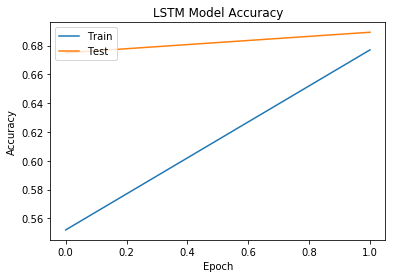

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

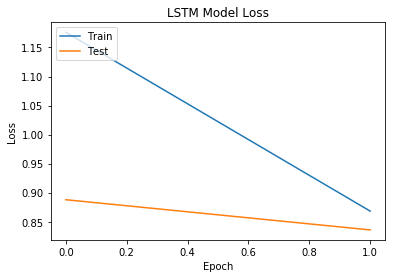

In [58]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

In [59]:
y_LSTM_val = model.predict(X_val_sent)
y_LSTM_train = model.predict(X_train_sent)

**The predicted sentiments are one hot encoded values. We need to convert them back to original.**

In [60]:
y_pred_lstm = np.argmax(y_LSTM_val, axis=1)
y_train_lstm = np.argmax(y_LSTM_train, axis=1)

In [61]:
print(len(y_pred_lstm), len(y_train_lstm))

204097 816387


In [66]:
print("=========================== \n\n TRAIN DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_train_sent, y_train_lstm))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_train_sent, y_train_lstm))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_train_sent, y_train_lstm))

print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val_sent, y_pred_lstm))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val_sent, y_pred_lstm))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val_sent, y_pred_lstm))


 TRAIN DATA METRICS



 Confusion Matrix

 [[ 44927   7347  12968   2805   4828]
 [  4670  50015  27270   9044   5004]
 [  9247  10830 314492  15796  11781]
 [  8595  12163  58646  73357  10700]
 [  1252   1145  19079  17650  82776]]



 Accuracy Score

 0.6927682581912745



 Classification Report

               precision    recall  f1-score   support

           0       0.65      0.62      0.63     72875
           1       0.61      0.52      0.56     96003
           2       0.73      0.87      0.79    362146
           3       0.62      0.45      0.52    163461
           4       0.72      0.68      0.70    121902

   micro avg       0.69      0.69      0.69    816387
   macro avg       0.67      0.63      0.64    816387
weighted avg       0.68      0.69      0.68    816387


 VALIDATION DATA METRICS



 Confusion Matrix

 [[11126  1897  3296   716  1184]
 [ 1253 12253  6941  2256  1297]
 [ 2392  2708 78417  4072  2948]
 [ 2172  2962 14670 18247  2814]
 [  309   275  4871  4511 2

In [67]:
test_pred_lstm = model.predict(X_test_sent)

In [68]:
y_LSTM_test = np.argmax(test_pred_lstm, axis=1)

In [69]:
len(y_LSTM_test)

260123

## Model Building

### Load Error Metrics

In [70]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,f1_score,precision_score
from sklearn.metrics import roc_curve,log_loss,auc

### Naives Bayes

In [71]:
from sklearn.naive_bayes import MultinomialNB

In [72]:
NBmodel = MultinomialNB().fit(x_sent_train, y_train_sent)

In [73]:
y_NB_pred = NBmodel.predict(x_sent_val)
y_NB_train = NBmodel.predict(x_sent_train)

In [74]:
print("=========================== \n\n TRAIN DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_train_sent, y_NB_train))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_train_sent, y_NB_train))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_train_sent, y_NB_train))

print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val_sent, y_NB_pred))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val_sent, y_NB_pred))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val_sent, y_NB_pred))


 TRAIN DATA METRICS



 Confusion Matrix

 [[ 14222  10429  34413  11901   1910]
 [   662  30220  47215  15266   2640]
 [   618  22637 296303  36769   5819]
 [   579  13836  80663  60610   7773]
 [   106   6024  49708  27197  38867]]



 Accuracy Score

 0.5392320063891267



 Classification Report

               precision    recall  f1-score   support

           0       0.88      0.20      0.32     72875
           1       0.36      0.31      0.34     96003
           2       0.58      0.82      0.68    362146
           3       0.40      0.37      0.38    163461
           4       0.68      0.32      0.43    121902

   micro avg       0.54      0.54      0.54    816387
   macro avg       0.58      0.40      0.43    816387
weighted avg       0.56      0.54      0.51    816387


 VALIDATION DATA METRICS



 Confusion Matrix

 [[ 3297  2505  8914  3036   467]
 [  216  6837 12159  4124   664]
 [  163  5343 73590  9909  1532]
 [  139  3624 21321 13571  2210]
 [   23  1452 12828  7522  

In [75]:
y_NB_test = NBmodel.predict(x_sent_test)

### Decision Tree

In [76]:
from sklearn import tree

In [77]:
DT_classifier = tree.DecisionTreeClassifier(random_state=2, criterion = 'entropy')

In [78]:
DT_classifier.fit(x_sent_train, y_train_sent)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=2,
            splitter='best')

In [79]:
y_DT_pred = DT_classifier.predict(x_sent_val)
y_DT_train = DT_classifier.predict(x_sent_train)

In [80]:
print("=========================== \n\n TRAIN DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_train_sent, y_DT_train))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_train_sent, y_DT_train))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_train_sent, y_DT_train))


print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val_sent, y_DT_pred))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val_sent, y_DT_pred))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val_sent, y_DT_pred))


 TRAIN DATA METRICS



 Confusion Matrix

 [[ 72698     14     79     19     65]
 [    82  95387    494     23     17]
 [   245    626 360908    290     77]
 [   116    149   2773 160372     51]
 [   217     72    449    224 120940]]



 Accuracy Score

 0.9925501018512054



 Classification Report

               precision    recall  f1-score   support

           0       0.99      1.00      0.99     72875
           1       0.99      0.99      0.99     96003
           2       0.99      1.00      0.99    362146
           3       1.00      0.98      0.99    163461
           4       1.00      0.99      1.00    121902

   micro avg       0.99      0.99      0.99    816387
   macro avg       0.99      0.99      0.99    816387
weighted avg       0.99      0.99      0.99    816387


 VALIDATION DATA METRICS



 Confusion Matrix

 [[ 9161  1970  3681  2174  1233]
 [ 2059 10348  6402  3340  1851]
 [ 3669  4994 67314  9931  4629]
 [ 2376  3134 12754 17563  5038]
 [ 1232  1654  5152  5034 1

In [81]:
y_DT_test = DT_classifier.predict(x_sent_test)

### Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [83]:
RF_classifier = RandomForestClassifier()

In [84]:
RF_classifier.fit(x_sent_train, y_train_sent)

C:\Users\UrMili\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
y_RF_pred = RF_classifier.predict(x_sent_val)
y_RF_train = RF_classifier.predict(x_sent_train)

In [86]:
print("=========================== \n\n TRAIN DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_train_sent, y_RF_train))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_train_sent, y_RF_train))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_train_sent, y_RF_train))


print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val_sent, y_RF_pred))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val_sent, y_RF_pred))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val_sent, y_RF_pred))


 TRAIN DATA METRICS



 Confusion Matrix

 [[ 71762    118    588    151    256]
 [   265  93467   1748    298    225]
 [   448    599 359309   1297    493]
 [   330    267   5791 156660    413]
 [   247    113   1373    888 119281]]



 Accuracy Score

 0.9805141434148266



 Classification Report

               precision    recall  f1-score   support

           0       0.98      0.98      0.98     72875
           1       0.99      0.97      0.98     96003
           2       0.97      0.99      0.98    362146
           3       0.98      0.96      0.97    163461
           4       0.99      0.98      0.98    121902

   micro avg       0.98      0.98      0.98    816387
   macro avg       0.98      0.98      0.98    816387
weighted avg       0.98      0.98      0.98    816387


 VALIDATION DATA METRICS



 Confusion Matrix

 [[ 9529  1782  4482  1407  1019]
 [ 1880 10007  7911  2703  1499]
 [ 2744  3197 74600  6630  3366]
 [ 1938  2297 16009 16865  3756]
 [  965   899  6150  4965 1

In [87]:
y_RF_sent_test = RF_classifier.predict(x_sent_test)

**Now that the sentiment analysis modelling is done. We choose to go ahead with the LSTM model prediction for test data since the model shows the least train and validation loss.**

## Adding the predicted Test data Sentiment Scores to The Final Test dataframe.

In [88]:
final_sent_test.head()

,ticker,month_of_tweet,day_of_tweet,tweet_length,no_of_hashtags,processed_tweets
0,CELG,10,25,27,0,nothing exit
1,AMD,7,13,55,0,yall exhaust buyer first green candle byeeeeee
2,AMD,9,25,16,0,day traders day
4,MU,7,31,101,0,weak price action far today dont afraid go sho...
5,AMZN,8,4,118,0,continue grow specifically key areas like clou...


In [89]:
final_sent_test['sentiment_score'] = y_LSTM_test

In [90]:
final_sent_test.head()

,ticker,month_of_tweet,day_of_tweet,tweet_length,no_of_hashtags,processed_tweets,sentiment_score
0,CELG,10,25,27,0,nothing exit,2
1,AMD,7,13,55,0,yall exhaust buyer first green candle byeeeeee,3
2,AMD,9,25,16,0,day traders day,2
4,MU,7,31,101,0,weak price action far today dont afraid go sho...,0
5,AMZN,8,4,118,0,continue grow specifically key areas like clou...,2


# Classification Model - DL

Now we built a model to predict alpha.

## Adding sentiment scores to the dataframe

In [91]:
train_data.head()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
0,0,1,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,21,8
1,1,2,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,11,10
2,2,3,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,21,8
3,3,4,ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,10,7
4,4,5,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,12,9


In [92]:
test_data.head()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,Month
0,0,270007,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,21,7
1,1,270008,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,5,10
2,2,270009,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,1,10
3,3,270010,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,24,10
4,4,270011,intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,27,7


In [93]:
final_sent_test.head()

,ticker,month_of_tweet,day_of_tweet,tweet_length,no_of_hashtags,processed_tweets,sentiment_score
0,CELG,10,25,27,0,nothing exit,2
1,AMD,7,13,55,0,yall exhaust buyer first green candle byeeeeee,3
2,AMD,9,25,16,0,day traders day,2
4,MU,7,31,101,0,weak price action far today dont afraid go sho...,0
5,AMZN,8,4,118,0,continue grow specifically key areas like clou...,2


In [94]:
final_sent_train.head()

,sentiment_score,ticker,month_of_tweet,day_of_tweet,tweet_length,no_of_hashtags,processed_tweets
0,3,AMD,9,19,70,0,go hesitate however chart stable go upward
1,3,CAT,10,9,42,0,despite china trade war hold well
2,2,AVGO,7,12,4,0,wtf
3,2,PH,7,19,64,0,new insider file muller klaus peter transactio...
4,3,FB,8,23,52,0,bounce tommorrow right thing gtfo


In [95]:
avg_sent_score_train = []

for i in tq(train_data['Unnamed: 0']):
    sleep(0.01)
    
    local_df_train = final_sent_train.loc[(final_sent_train['day_of_tweet'] == train_data['Day'][i]) & 
                                    (final_sent_train['month_of_tweet'] == train_data['Month'][i]) & 
                                    (final_sent_train['ticker'] == train_data['ticker'][i])]
    
    avg_sent_score_train.append(round(local_df_train['sentiment_score'].sum()/local_df_train.shape[0]))
    
train_data['sentiment'] = avg_sent_score_train

C:\Users\UrMili\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


In [96]:
train_data.tail()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month,sentiment
27001,27001,27002,RF,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3,5,10,1.0
27002,27002,27003,PG,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3,30,7,2.0
27003,27003,27004,JCP,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2,16,10,2.0
27004,27004,27005,NVDA,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3,27,7,2.0
27005,27005,27006,WBA,-0.637959,0.621395,-0.636104,-0.810184,1.587782,-0.413540,0.101924,2,14,10,2.0


In [97]:
avg_sent_score_test = []

for i in tq(test_data['Unnamed: 0']):
    sleep(0.01)
    
    local_df_test = final_sent_test.loc[(final_sent_test['day_of_tweet'] == test_data['Day'][i]) & 
                                    (final_sent_test['month_of_tweet'] == test_data['Month'][i]) & 
                                    (final_sent_test['ticker'] == test_data['ticker'][i])]
    
    avg_sent_score_test.append(round(local_df_test['sentiment_score'].sum()/local_df_test.shape[0]))
    
test_data['sentiment'] = avg_sent_score_test

C:\Users\UrMili\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in longlong_scalars
  # Remove the CWD from sys.path while we load stuff.


In [98]:
test_data.tail()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,Month,sentiment
11570,11570,281577,T,-3.442316,0.455191,0.941669,-0.834807,0.278606,-0.233547,-2.755514,3,10,2.0
11571,11571,281578,WFC,-1.650993,-0.499109,-0.771762,-2.645119,2.374321,-0.200878,0.353774,21,8,2.0
11572,11572,281579,MAT,-1.578543,1.482062,0.672188,0.908843,-0.259848,-0.136924,-2.101467,11,8,2.0
11573,11573,281580,RF,-0.027608,0.811717,-0.148925,-0.700263,0.263678,-0.180345,0.435261,22,7,2.0
11574,11574,281581,bbby,0.591726,0.435771,-0.009138,-0.912432,-0.410299,0.072242,1.063584,26,7,2.0


## Preparing DataFrame for prediction

In [99]:
train_data.head()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month,sentiment
0,0,1,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,21,8,2.0
1,1,2,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,11,10,2.0
2,2,3,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,21,8,2.0
3,3,4,ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,10,7,2.0
4,4,5,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,12,9,0.0


In [100]:
train_data.dtypes

Unnamed: 0       int64
Id               int64
ticker        category
SF1            float64
SF2            float64
SF3            float64
SF4            float64
SF5            float64
SF6            float64
SF7            float64
alpha            int64
Day              int64
Month            int64
sentiment      float64
dtype: object

In [102]:
train_data.isna().sum()

Unnamed: 0       0
Id               0
ticker           5
SF1              0
SF2              0
SF3              0
SF4              0
SF5              0
SF6              0
SF7              0
alpha            0
Day              0
Month            0
sentiment     2683
dtype: int64

In [103]:
train_data['sentiment'] = train_data['sentiment'].fillna(train_data['sentiment'].mode()[0])

In [104]:
train_data = train_data.dropna()

In [105]:
train_data['sentiment'] = train_data['sentiment'].astype('int')

In [106]:
test_data.head()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,Month,sentiment
0,0,270007,INTC,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,21,7,3.0
1,1,270008,CTSH,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,5,10,3.0
2,2,270009,CB,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,1,10,2.0
3,3,270010,CTAS,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,24,10,2.0
4,4,270011,intc,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,27,7,3.0


In [107]:
test_data.dtypes

Unnamed: 0       int64
Id               int64
ticker        category
SF1            float64
SF2            float64
SF3            float64
SF4            float64
SF5            float64
SF6            float64
SF7            float64
Day              int64
Month            int64
sentiment      float64
dtype: object

In [108]:
test_data.isna().sum()

Unnamed: 0     0
Id             0
ticker         0
SF1            0
SF2            0
SF3            0
SF4            0
SF5            0
SF6            0
SF7            0
Day            0
Month          0
sentiment     23
dtype: int64

In [109]:
test_data['sentiment'] = test_data['sentiment'].fillna(test_data['sentiment'].mode()[0])

In [111]:
test_data['sentiment'] = test_data['sentiment'].astype('int')

## One Hot Encoding

In [112]:
train_encoded = pd.get_dummies(train_data)
test_encoded = pd.get_dummies(test_data)

In [113]:
train_encoded.tail()

,Unnamed: 0,Id,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,...,ticker_x,ticker_xec,ticker_xlnx,ticker_xom,ticker_xray,ticker_xrt,ticker_yum,ticker_zbh,ticker_zion,ticker_zts
27001,27001,27002,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3,...,0,0,0,0,0,0,0,0,0,0
27002,27002,27003,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3,...,0,0,0,0,0,0,0,0,0,0
27003,27003,27004,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2,...,0,0,0,0,0,0,0,0,0,0
27004,27004,27005,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3,...,0,0,0,0,0,0,0,0,0,0
27005,27005,27006,-0.637959,0.621395,-0.636104,-0.810184,1.587782,-0.413540,0.101924,2,...,0,0,0,0,0,0,0,0,0,0


In [114]:
test_encoded.tail()

,Unnamed: 0,Id,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,...,ticker_wdc,ticker_wfc,ticker_whr,ticker_wmt,ticker_wy,ticker_wynn,ticker_x,ticker_xlnx,ticker_xom,ticker_zbh
11570,11570,281577,-3.442316,0.455191,0.941669,-0.834807,0.278606,-0.233547,-2.755514,3,...,0,0,0,0,0,0,0,0,0,0
11571,11571,281578,-1.650993,-0.499109,-0.771762,-2.645119,2.374321,-0.200878,0.353774,21,...,0,0,0,0,0,0,0,0,0,0
11572,11572,281579,-1.578543,1.482062,0.672188,0.908843,-0.259848,-0.136924,-2.101467,11,...,0,0,0,0,0,0,0,0,0,0
11573,11573,281580,-0.027608,0.811717,-0.148925,-0.700263,0.263678,-0.180345,0.435261,22,...,0,0,0,0,0,0,0,0,0,0
11574,11574,281581,0.591726,0.435771,-0.009138,-0.912432,-0.410299,0.072242,1.063584,26,...,0,0,0,0,0,0,0,0,0,0


In [115]:
test_encoded = test_encoded.reindex(columns = train_encoded.columns, fill_value=0)

In [116]:
test_encoded.tail()

,Unnamed: 0,Id,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,...,ticker_x,ticker_xec,ticker_xlnx,ticker_xom,ticker_xray,ticker_xrt,ticker_yum,ticker_zbh,ticker_zion,ticker_zts
11570,11570,281577,-3.442316,0.455191,0.941669,-0.834807,0.278606,-0.233547,-2.755514,0,...,0,0,0,0,0,0,0,0,0,0
11571,11571,281578,-1.650993,-0.499109,-0.771762,-2.645119,2.374321,-0.200878,0.353774,0,...,0,0,0,0,0,0,0,0,0,0
11572,11572,281579,-1.578543,1.482062,0.672188,0.908843,-0.259848,-0.136924,-2.101467,0,...,0,0,0,0,0,0,0,0,0,0
11573,11573,281580,-0.027608,0.811717,-0.148925,-0.700263,0.263678,-0.180345,0.435261,0,...,0,0,0,0,0,0,0,0,0,0
11574,11574,281581,0.591726,0.435771,-0.009138,-0.912432,-0.410299,0.072242,1.063584,0,...,0,0,0,0,0,0,0,0,0,0


## Dropping Columns - ID

In [117]:
train_encoded = train_encoded.drop(columns = ['Id', 'Unnamed: 0'])
test_encoded = test_encoded.drop(columns = ['Id', 'Unnamed: 0'])

## Splitting X & Y

In [118]:
X = train_encoded.drop(columns = 'alpha')
y = train_encoded['alpha']

In [119]:
df_test = test_encoded.drop(columns='alpha')

## Train - Validation Split

In [121]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 26, stratify = y)

print('X Train dimensions: \n\n', x_train.shape, '\n\nX Validation dimensions: \n\n', x_val.shape, 
      '\n\nY Train dimensions:\n\n', y_train.shape, '\n\n Y Validation dimensions: \n\n', y_val.shape)

X Train dimensions: 

 (21600, 1309) 

X Validation dimensions: 

 (5401, 1309) 

Y Train dimensions:

 (21600,) 

 Y Validation dimensions: 

 (5401,)


## Model Building

### Decision Tree

In [124]:
from sklearn import tree

DT_classifier = tree.DecisionTreeClassifier(random_state=26, criterion = 'entropy')

DT_classifier.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=26,
            splitter='best')

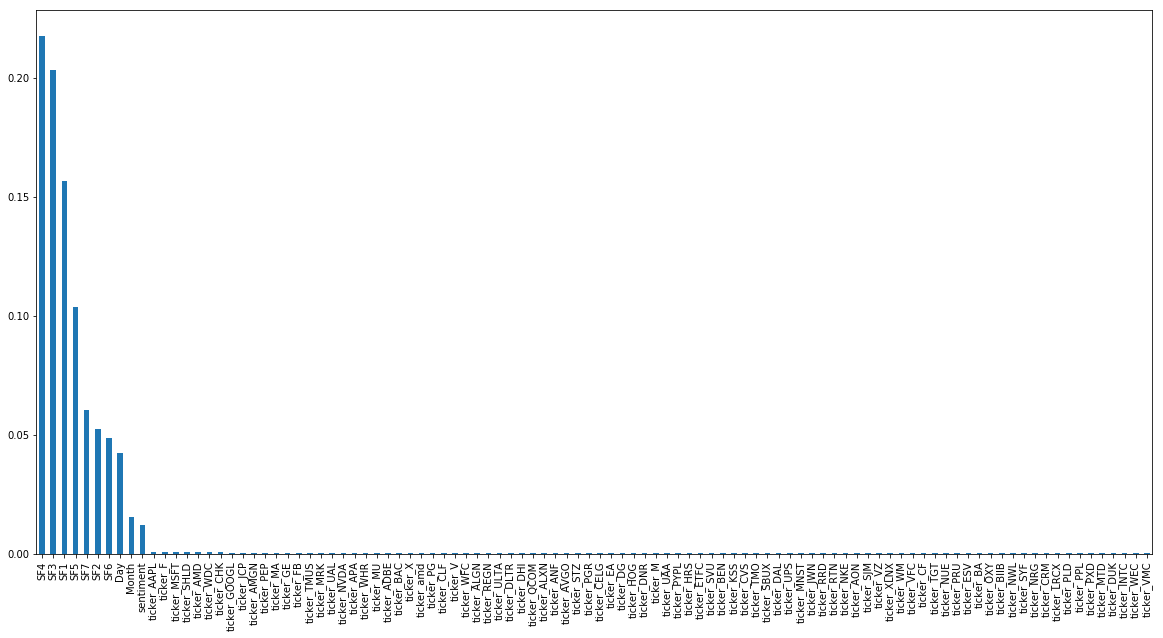

In [125]:
imp_feature = pd.Series(DT_classifier.feature_importances_, index = x_train.columns)
imp_ordered = imp_feature.nlargest(100)
plt.rcParams['figure.figsize'] = (20,10)
imp_ordered.plot(kind = 'bar')

In [126]:
y_DT_pred = DT_classifier.predict(x_val)
y_DT_train = DT_classifier.predict(x_train)

print("=========================== \n\n TRAIN DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_train, y_DT_train))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_train, y_DT_train))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_train, y_DT_train))


print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val, y_DT_pred))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val, y_DT_pred))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val, y_DT_pred))


 TRAIN DATA METRICS



 Confusion Matrix

 [[4373    0    0    0]
 [   0 8728    0    0]
 [   0    0 4428    0]
 [   0    0    0 4071]]



 Accuracy Score

 1.0



 Classification Report

               precision    recall  f1-score   support

           1       1.00      1.00      1.00      4373
           2       1.00      1.00      1.00      8728
           3       1.00      1.00      1.00      4428
           4       1.00      1.00      1.00      4071

   micro avg       1.00      1.00      1.00     21600
   macro avg       1.00      1.00      1.00     21600
weighted avg       1.00      1.00      1.00     21600


 VALIDATION DATA METRICS



 Confusion Matrix

 [[ 559  148  249  137]
 [ 111 1774  153  144]
 [ 255  162  510  181]
 [ 156  158  167  537]]



 Accuracy Score

 0.6258100351786706



 Classification Report

               precision    recall  f1-score   support

           1       0.52      0.51      0.51      1093
           2       0.79      0.81      0.80      2182
  

In [127]:
y_DT_test = DT_classifier.predict(df_test)

In [128]:
DT_pred_file = {'Id': test_data['Id'], 'alpha': y_DT_test}

DT_pred_file = pd.DataFrame(DT_pred_file)

DT_pred_file.to_csv('Decision_Tree_Sentiment_Prediction.csv', index = False)

### Random Forest

In [129]:
RF_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=26)

In [130]:
RF_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=26, verbose=0, warm_start=False)

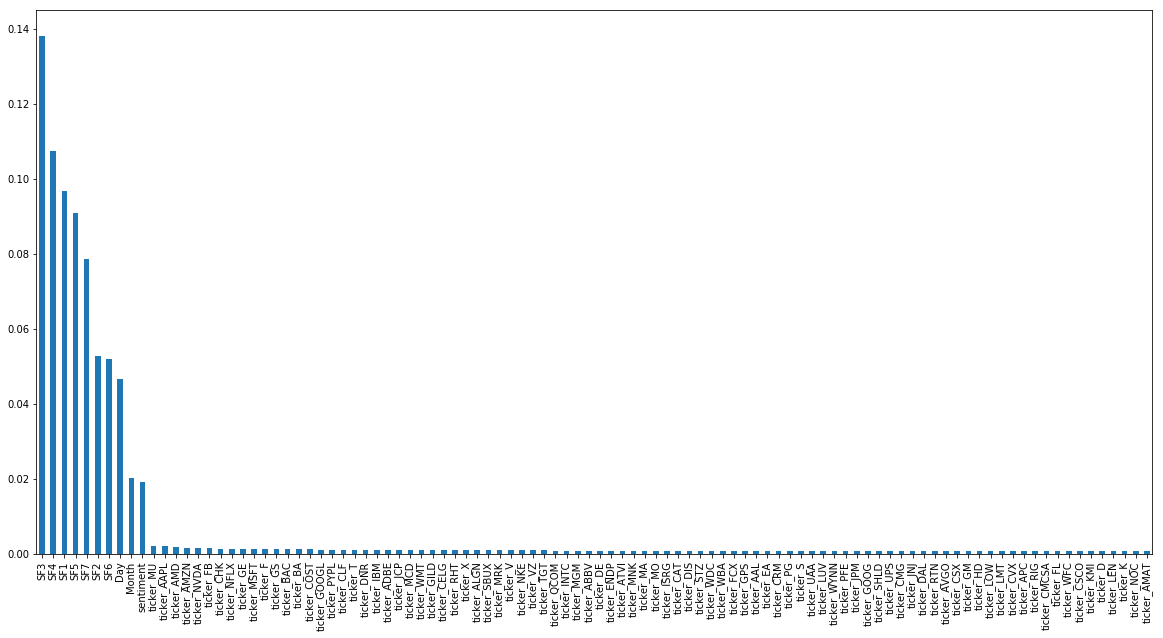

In [131]:
feat_importances = pd.Series(RF_classifier.feature_importances_, index = x_train.columns)
feat_importances_ordered = feat_importances.nlargest(100)
feat_importances_ordered.plot(kind='bar')

In [132]:
y_RF_pred = RF_classifier.predict(x_val)
y_RF_train = RF_classifier.predict(x_train)

In [133]:
print("=========================== \n\n TRAIN DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_train, y_RF_train))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_train, y_RF_train))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_train, y_RF_train))


print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val, y_RF_pred))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val, y_RF_pred))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val, y_RF_pred))


 TRAIN DATA METRICS



 Confusion Matrix

 [[4323   33    7   10]
 [   7 8713    5    3]
 [  28   71 4322    7]
 [  15   72   29 3955]]



 Accuracy Score

 0.986712962962963



 Classification Report

               precision    recall  f1-score   support

           1       0.99      0.99      0.99      4373
           2       0.98      1.00      0.99      8728
           3       0.99      0.98      0.98      4428
           4       0.99      0.97      0.98      4071

   micro avg       0.99      0.99      0.99     21600
   macro avg       0.99      0.98      0.99     21600
weighted avg       0.99      0.99      0.99     21600


 VALIDATION DATA METRICS



 Confusion Matrix

 [[ 564  296  123  110]
 [  64 1961   72   85]
 [ 222  283  491  112]
 [ 136  364  136  382]]



 Accuracy Score

 0.629142751342344



 Classification Report

               precision    recall  f1-score   support

           1       0.57      0.52      0.54      1093
           2       0.68      0.90      0.77

In [134]:
y_RF_test = RF_classifier.predict(df_test)

In [135]:
RF_pred_file = {'Id': test_data['Id'], 'alpha': y_RF_test}

RF_pred_file = pd.DataFrame(RF_pred_file)

RF_pred_file.to_csv('Random_Forest_Sentiment_Prediction.csv', index = False)